In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import re
import seaborn as sns
from utils import pad_images
#sns.set_palette('colorblind')
#sns.set_style('darkgrid')
global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from model import RegressionModel
import torchvision.transforms as transforms
from model import CustomAugmentation

In [2]:
import random
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  # If using GPU
torch.backends.cudnn.benchmark = False    # If using GPU


# Read and Preprocess images

In [3]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('data')):
    for filename in tqdm(sorted(filenames)):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data, dtype='object')

100%|██████████| 2048/2048 [00:00<00:00, 4176.06it/s]


In [4]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
padded_data.shape

(2048, 256, 256, 1)

In [5]:
# Transpose to feed into torch model
data_t = np.transpose(padded_data, (0, 3, 1, 2))

In [6]:
X = data_t.copy()/255
y = pd.read_csv('label.csv')['label'].values
del padded_data
del data_t
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
del X, y
torch.cuda.empty_cache()

In [9]:
#define data loaders
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train).to(device=device, dtype=torch.float), torch.from_numpy(y_train).to(device=device, dtype=torch.float))
#val_data = torch.utils.data.TensorDataset(torch.from_numpy(X_val).to(device=device, dtype=torch.float), torch.from_numpy(y_val).to(device=device, dtype=torch.float))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test).to(device=device, dtype=torch.float), torch.from_numpy(y_test).to(device=device, dtype=torch.float))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

del X_train, y_train, train_data, test_data

torch.cuda.empty_cache()


In [10]:
regression_model = RegressionModel().to(device)
regression_model.load_state_dict(torch.load('model2.pth'))
criterion = nn.MSELoss()

# Model Construction

In [11]:
def train(model,X_train,y_train, lr, epochs):
    model = RegressionModel().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    for epoch in (range(epochs)):
        for images, labels in (train_loader):
            print (images.shape)
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()



In [47]:
# Define loss function and optimizer
regression_model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(regression_model.parameters(), lr=0.002500850964289255)
c = CustomAugmentation()

# Training loop
num_epochs =500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model.to(device)
train_loss = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    val_loss = []

    for images, targets in train_loader:
        images = c(images)
        regression_model.train()
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = regression_model(images)
        loss = criterion(outputs.squeeze(), targets.float()) 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        #validate
        regression_model.eval()
        total_val_loss = 0
    train_loss.append(total_loss / len(train_loader))

    


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")
    #print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss/len(val_loader)}")


  0%|          | 1/500 [00:19<2:43:18, 19.64s/it]

Epoch 1/500, Loss: 83808.00931490384


  0%|          | 2/500 [00:39<2:45:33, 19.95s/it]

Epoch 2/500, Loss: 83229.92548076923


  1%|          | 3/500 [00:55<2:28:06, 17.88s/it]

Epoch 3/500, Loss: 82217.38566706731


  1%|          | 4/500 [01:09<2:17:33, 16.64s/it]

Epoch 4/500, Loss: 79784.19456129808


  1%|          | 5/500 [01:30<2:27:43, 17.91s/it]

Epoch 5/500, Loss: 63028.574669471156


  1%|          | 6/500 [01:46<2:22:53, 17.36s/it]

Epoch 6/500, Loss: 41601.81618088942


  1%|▏         | 7/500 [02:01<2:17:16, 16.71s/it]

Epoch 7/500, Loss: 39471.32797475962


  2%|▏         | 8/500 [02:17<2:13:16, 16.25s/it]

Epoch 8/500, Loss: 47104.62560096154


  2%|▏         | 9/500 [02:32<2:10:21, 15.93s/it]

Epoch 9/500, Loss: 34116.61290564904


  2%|▏         | 10/500 [02:47<2:08:14, 15.70s/it]

Epoch 10/500, Loss: 38280.351374699516


  2%|▏         | 11/500 [03:02<2:06:36, 15.53s/it]

Epoch 11/500, Loss: 33216.733097956734


  2%|▏         | 12/500 [03:17<2:05:18, 15.41s/it]

Epoch 12/500, Loss: 31142.857572115383


  3%|▎         | 13/500 [03:32<2:04:13, 15.30s/it]

Epoch 13/500, Loss: 22315.4931640625


  3%|▎         | 14/500 [03:47<2:03:21, 15.23s/it]

Epoch 14/500, Loss: 19063.71259014423


  3%|▎         | 15/500 [04:02<2:02:40, 15.18s/it]

Epoch 15/500, Loss: 17842.823636568508


  3%|▎         | 16/500 [04:17<2:02:06, 15.14s/it]

Epoch 16/500, Loss: 13066.679086538461


  3%|▎         | 17/500 [04:33<2:01:40, 15.12s/it]

Epoch 17/500, Loss: 21885.02430138221


  4%|▎         | 18/500 [04:48<2:01:14, 15.09s/it]

Epoch 18/500, Loss: 14411.629375751201


  4%|▍         | 19/500 [05:03<2:00:50, 15.07s/it]

Epoch 19/500, Loss: 18591.471848707934


  4%|▍         | 20/500 [05:18<2:00:30, 15.06s/it]

Epoch 20/500, Loss: 11878.34384390024


  4%|▍         | 21/500 [05:33<2:00:14, 15.06s/it]

Epoch 21/500, Loss: 16082.897413987379


  4%|▍         | 22/500 [05:48<2:00:05, 15.07s/it]

Epoch 22/500, Loss: 13850.924973707934


  5%|▍         | 23/500 [06:03<1:59:57, 15.09s/it]

Epoch 23/500, Loss: 12119.084979717549


  5%|▍         | 24/500 [06:18<1:59:49, 15.10s/it]

Epoch 24/500, Loss: 8994.190805288461


  5%|▌         | 25/500 [06:33<1:59:30, 15.10s/it]

Epoch 25/500, Loss: 11056.349712665264


  5%|▌         | 26/500 [06:48<1:59:03, 15.07s/it]

Epoch 26/500, Loss: 5837.4720130333535


  5%|▌         | 27/500 [07:03<1:58:35, 15.04s/it]

Epoch 27/500, Loss: 4908.376868614783


  6%|▌         | 28/500 [07:18<1:58:09, 15.02s/it]

Epoch 28/500, Loss: 5111.359177809495


  6%|▌         | 29/500 [07:33<1:57:47, 15.00s/it]

Epoch 29/500, Loss: 5166.1208261343145


  6%|▌         | 30/500 [07:48<1:57:23, 14.99s/it]

Epoch 30/500, Loss: 17057.057063176082


  6%|▌         | 31/500 [08:03<1:57:08, 14.99s/it]

Epoch 31/500, Loss: 16051.477107121395


  6%|▋         | 32/500 [08:18<1:56:58, 15.00s/it]

Epoch 32/500, Loss: 7642.07035945012


  7%|▋         | 33/500 [08:33<1:56:51, 15.01s/it]

Epoch 33/500, Loss: 6851.830791766827


  7%|▋         | 34/500 [08:48<1:56:46, 15.04s/it]

Epoch 34/500, Loss: 4899.2277268629805


  7%|▋         | 35/500 [09:03<1:56:39, 15.05s/it]

Epoch 35/500, Loss: 4391.844566932092


  7%|▋         | 36/500 [09:18<1:56:22, 15.05s/it]

Epoch 36/500, Loss: 2842.942880483774


  7%|▋         | 37/500 [09:33<1:55:54, 15.02s/it]

Epoch 37/500, Loss: 6975.363206129808


  8%|▊         | 38/500 [09:48<1:55:30, 15.00s/it]

Epoch 38/500, Loss: 6434.629962627704


  8%|▊         | 39/500 [10:03<1:55:11, 14.99s/it]

Epoch 39/500, Loss: 4141.147465632512


  8%|▊         | 40/500 [10:18<1:54:54, 14.99s/it]

Epoch 40/500, Loss: 4803.337533804087


  8%|▊         | 41/500 [10:33<1:54:37, 14.98s/it]

Epoch 41/500, Loss: 7893.169180063101


  8%|▊         | 42/500 [10:48<1:54:23, 14.99s/it]

Epoch 42/500, Loss: 6082.8831458458535


  9%|▊         | 43/500 [11:03<1:54:08, 14.99s/it]

Epoch 43/500, Loss: 5835.03964468149


  9%|▉         | 44/500 [11:18<1:53:56, 14.99s/it]

Epoch 44/500, Loss: 12086.92294546274


  9%|▉         | 45/500 [11:33<1:53:44, 15.00s/it]

Epoch 45/500, Loss: 3963.8800330528848


  9%|▉         | 46/500 [11:48<1:53:34, 15.01s/it]

Epoch 46/500, Loss: 2965.9497844989482


  9%|▉         | 47/500 [12:03<1:53:26, 15.02s/it]

Epoch 47/500, Loss: 2756.680225078876


 10%|▉         | 48/500 [12:18<1:53:16, 15.04s/it]

Epoch 48/500, Loss: 2639.2688598632812


 10%|▉         | 49/500 [12:33<1:53:05, 15.05s/it]

Epoch 49/500, Loss: 2747.9722454364482


 10%|█         | 50/500 [12:48<1:52:57, 15.06s/it]

Epoch 50/500, Loss: 2768.456092247596


 10%|█         | 51/500 [13:04<1:52:49, 15.08s/it]

Epoch 51/500, Loss: 3700.7985417292666


 10%|█         | 52/500 [13:19<1:52:42, 15.10s/it]

Epoch 52/500, Loss: 2700.4120366023135


 11%|█         | 53/500 [13:34<1:52:38, 15.12s/it]

Epoch 53/500, Loss: 2413.0155170147236


 11%|█         | 54/500 [13:49<1:52:30, 15.14s/it]

Epoch 54/500, Loss: 2508.209298940805


 11%|█         | 55/500 [14:04<1:52:20, 15.15s/it]

Epoch 55/500, Loss: 1806.0726200984075


 11%|█         | 56/500 [14:19<1:52:09, 15.16s/it]

Epoch 56/500, Loss: 5235.054905818059


 11%|█▏        | 57/500 [14:35<1:51:56, 15.16s/it]

Epoch 57/500, Loss: 4408.326007549579


 12%|█▏        | 58/500 [14:50<1:51:43, 15.17s/it]

Epoch 58/500, Loss: 2439.2088529146636


 12%|█▏        | 59/500 [15:05<1:51:29, 15.17s/it]

Epoch 59/500, Loss: 4459.012932410607


 12%|█▏        | 60/500 [15:20<1:51:18, 15.18s/it]

Epoch 60/500, Loss: 4576.404019869291


 12%|█▏        | 61/500 [15:35<1:51:07, 15.19s/it]

Epoch 61/500, Loss: 4051.514836237981


 12%|█▏        | 62/500 [15:51<1:50:56, 15.20s/it]

Epoch 62/500, Loss: 4123.217909592849


 13%|█▎        | 63/500 [16:06<1:50:46, 15.21s/it]

Epoch 63/500, Loss: 2406.8787536621094


 13%|█▎        | 64/500 [16:21<1:50:35, 15.22s/it]

Epoch 64/500, Loss: 2661.688687838041


 13%|█▎        | 65/500 [16:36<1:50:25, 15.23s/it]

Epoch 65/500, Loss: 2580.640141413762


 13%|█▎        | 66/500 [16:52<1:50:13, 15.24s/it]

Epoch 66/500, Loss: 2582.7393657977764


 13%|█▎        | 67/500 [17:07<1:50:01, 15.25s/it]

Epoch 67/500, Loss: 1924.4573458158052


 14%|█▎        | 68/500 [17:22<1:49:50, 15.26s/it]

Epoch 68/500, Loss: 1964.1698620135967


 14%|█▍        | 69/500 [17:37<1:49:39, 15.26s/it]

Epoch 69/500, Loss: 8236.661940354566


 14%|█▍        | 70/500 [17:53<1:49:23, 15.26s/it]

Epoch 70/500, Loss: 5466.000375600962


 14%|█▍        | 71/500 [18:08<1:49:08, 15.27s/it]

Epoch 71/500, Loss: 3427.30122258113


 14%|█▍        | 72/500 [18:23<1:48:53, 15.26s/it]

Epoch 72/500, Loss: 2741.0377103365386


 15%|█▍        | 73/500 [18:38<1:48:38, 15.27s/it]

Epoch 73/500, Loss: 2675.7827430138223


 15%|█▍        | 74/500 [18:54<1:48:21, 15.26s/it]

Epoch 74/500, Loss: 2375.8067439152646


 15%|█▌        | 75/500 [19:09<1:48:08, 15.27s/it]

Epoch 75/500, Loss: 2309.934624305138


 15%|█▌        | 76/500 [19:24<1:47:55, 15.27s/it]

Epoch 76/500, Loss: 2002.3086500901443


 15%|█▌        | 77/500 [19:40<1:47:41, 15.28s/it]

Epoch 77/500, Loss: 1415.5170194185698


 16%|█▌        | 78/500 [19:55<1:47:30, 15.29s/it]

Epoch 78/500, Loss: 2510.3111877441406


 16%|█▌        | 79/500 [20:10<1:47:17, 15.29s/it]

Epoch 79/500, Loss: 2255.7811396672178


 16%|█▌        | 80/500 [20:29<1:54:45, 16.39s/it]

Epoch 80/500, Loss: 1450.2921036940354


 16%|█▌        | 81/500 [20:49<2:01:02, 17.33s/it]

Epoch 81/500, Loss: 1711.5636033278245


 16%|█▋        | 82/500 [21:08<2:05:28, 18.01s/it]

Epoch 82/500, Loss: 1320.0773749718298


 17%|█▋        | 83/500 [21:28<2:08:39, 18.51s/it]

Epoch 83/500, Loss: 3319.0230806790864


 17%|█▋        | 84/500 [21:48<2:11:07, 18.91s/it]

Epoch 84/500, Loss: 3134.6221876878003


 17%|█▋        | 85/500 [22:08<2:14:05, 19.39s/it]

Epoch 85/500, Loss: 2498.999448336088


 17%|█▋        | 86/500 [22:29<2:16:58, 19.85s/it]

Epoch 86/500, Loss: 1740.4902883676382


 17%|█▋        | 87/500 [22:51<2:19:42, 20.30s/it]

Epoch 87/500, Loss: 2672.1232229379507


 18%|█▊        | 88/500 [23:12<2:21:54, 20.67s/it]

Epoch 88/500, Loss: 2571.705801156851


 18%|█▊        | 89/500 [23:34<2:23:33, 20.96s/it]

Epoch 89/500, Loss: 2041.5667982835037


 18%|█▊        | 90/500 [23:55<2:24:54, 21.21s/it]

Epoch 90/500, Loss: 1542.1175959660457


 18%|█▊        | 91/500 [24:17<2:26:07, 21.44s/it]

Epoch 91/500, Loss: 1548.0344449556792


 18%|█▊        | 92/500 [24:40<2:27:24, 21.68s/it]

Epoch 92/500, Loss: 4947.242936354417


 19%|█▊        | 93/500 [25:02<2:28:35, 21.90s/it]

Epoch 93/500, Loss: 2680.496779221755


 19%|█▉        | 94/500 [25:24<2:29:06, 22.04s/it]

Epoch 94/500, Loss: 2150.645258976863


 19%|█▉        | 95/500 [25:47<2:29:29, 22.15s/it]

Epoch 95/500, Loss: 1615.6198871319111


 19%|█▉        | 96/500 [26:10<2:30:13, 22.31s/it]

Epoch 96/500, Loss: 1948.238276554988


 19%|█▉        | 97/500 [26:32<2:30:47, 22.45s/it]

Epoch 97/500, Loss: 1431.798823429988


 20%|█▉        | 98/500 [26:55<2:31:23, 22.60s/it]

Epoch 98/500, Loss: 1813.1451380803035


 20%|█▉        | 99/500 [27:18<2:31:55, 22.73s/it]

Epoch 99/500, Loss: 2473.148702768179


 20%|██        | 100/500 [27:41<2:31:51, 22.78s/it]

Epoch 100/500, Loss: 4421.851459209735


 20%|██        | 101/500 [28:04<2:31:48, 22.83s/it]

Epoch 101/500, Loss: 6568.497586763822


 20%|██        | 102/500 [28:27<2:31:49, 22.89s/it]

Epoch 102/500, Loss: 9900.264399601863


 21%|██        | 103/500 [28:50<2:31:51, 22.95s/it]

Epoch 103/500, Loss: 7485.794893704928


 21%|██        | 104/500 [29:13<2:31:54, 23.02s/it]

Epoch 104/500, Loss: 3574.3517643855166


 21%|██        | 105/500 [29:37<2:32:03, 23.10s/it]

Epoch 105/500, Loss: 3731.3499521108774


 21%|██        | 106/500 [30:00<2:31:54, 23.13s/it]

Epoch 106/500, Loss: 2981.3206693209136


 21%|██▏       | 107/500 [30:23<2:31:23, 23.11s/it]

Epoch 107/500, Loss: 3540.1231407752402


 22%|██▏       | 108/500 [30:46<2:31:01, 23.12s/it]

Epoch 108/500, Loss: 15965.434795673076


 22%|██▏       | 109/500 [31:09<2:30:37, 23.11s/it]

Epoch 109/500, Loss: 4300.395465557392


 22%|██▏       | 110/500 [31:32<2:30:10, 23.10s/it]

Epoch 110/500, Loss: 2517.8220731295073


 22%|██▏       | 111/500 [31:55<2:29:40, 23.09s/it]

Epoch 111/500, Loss: 1632.6313335712139


 22%|██▏       | 112/500 [32:19<2:29:32, 23.12s/it]

Epoch 112/500, Loss: 1423.5172706017127


 23%|██▎       | 113/500 [32:41<2:28:44, 23.06s/it]

Epoch 113/500, Loss: 1249.7994924692007


 23%|██▎       | 114/500 [33:04<2:26:57, 22.84s/it]

Epoch 114/500, Loss: 1515.3122224074143


 23%|██▎       | 115/500 [33:26<2:24:46, 22.56s/it]

Epoch 115/500, Loss: 1000.2709291898287


 23%|██▎       | 116/500 [33:47<2:21:46, 22.15s/it]

Epoch 116/500, Loss: 1970.0904329740083


 23%|██▎       | 117/500 [34:08<2:20:07, 21.95s/it]

Epoch 117/500, Loss: 1080.7543334960938


 24%|██▎       | 118/500 [34:30<2:18:28, 21.75s/it]

Epoch 118/500, Loss: 1166.6436943641077


 24%|██▍       | 119/500 [34:51<2:16:50, 21.55s/it]

Epoch 119/500, Loss: 831.3787143413837


 24%|██▍       | 120/500 [35:12<2:15:25, 21.38s/it]

Epoch 120/500, Loss: 786.9907502394456


 24%|██▍       | 121/500 [35:33<2:14:32, 21.30s/it]

Epoch 121/500, Loss: 752.3027648925781


 24%|██▍       | 122/500 [35:54<2:13:58, 21.26s/it]

Epoch 122/500, Loss: 915.9803173358624


 25%|██▍       | 123/500 [36:15<2:13:25, 21.23s/it]

Epoch 123/500, Loss: 681.8900657066932


 25%|██▍       | 124/500 [36:36<2:12:50, 21.20s/it]

Epoch 124/500, Loss: 887.1398379986102


 25%|██▌       | 125/500 [36:57<2:12:13, 21.16s/it]

Epoch 125/500, Loss: 729.2892444317157


 25%|██▌       | 126/500 [37:18<2:11:35, 21.11s/it]

Epoch 126/500, Loss: 794.1108809251052


 25%|██▌       | 127/500 [37:39<2:10:57, 21.07s/it]

Epoch 127/500, Loss: 894.3176727294922


 26%|██▌       | 128/500 [38:00<2:09:57, 20.96s/it]

Epoch 128/500, Loss: 843.4344811072716


 26%|██▌       | 129/500 [38:21<2:08:59, 20.86s/it]

Epoch 129/500, Loss: 977.2410102257362


 26%|██▌       | 130/500 [38:41<2:08:22, 20.82s/it]

Epoch 130/500, Loss: 701.489991408128


 26%|██▌       | 131/500 [39:02<2:08:10, 20.84s/it]

Epoch 131/500, Loss: 750.9778477595403


 26%|██▋       | 132/500 [39:23<2:07:59, 20.87s/it]

Epoch 132/500, Loss: 539.3079135601337


 27%|██▋       | 133/500 [39:44<2:07:44, 20.88s/it]

Epoch 133/500, Loss: 997.2976573063777


 27%|██▋       | 134/500 [40:05<2:07:30, 20.90s/it]

Epoch 134/500, Loss: 818.5697508591873


 27%|██▋       | 135/500 [40:26<2:07:17, 20.93s/it]

Epoch 135/500, Loss: 680.5364051231971


 27%|██▋       | 136/500 [40:47<2:06:59, 20.93s/it]

Epoch 136/500, Loss: 631.8899495051458


 27%|██▋       | 137/500 [41:08<2:06:41, 20.94s/it]

Epoch 137/500, Loss: 799.0797447791466


 28%|██▊       | 138/500 [41:29<2:06:17, 20.93s/it]

Epoch 138/500, Loss: 588.6625260573167


 28%|██▊       | 139/500 [41:50<2:05:58, 20.94s/it]

Epoch 139/500, Loss: 930.8002061110276


 28%|██▊       | 140/500 [42:11<2:05:34, 20.93s/it]

Epoch 140/500, Loss: 725.7625116201548


 28%|██▊       | 141/500 [42:32<2:05:17, 20.94s/it]

Epoch 141/500, Loss: 617.4699795062726


 28%|██▊       | 142/500 [42:53<2:05:00, 20.95s/it]

Epoch 142/500, Loss: 748.125733595628


 29%|██▊       | 143/500 [43:14<2:04:39, 20.95s/it]

Epoch 143/500, Loss: 571.4129861684946


 29%|██▉       | 144/500 [43:35<2:04:08, 20.92s/it]

Epoch 144/500, Loss: 444.59603236271784


 29%|██▉       | 145/500 [43:55<2:03:50, 20.93s/it]

Epoch 145/500, Loss: 514.1774432842548


 29%|██▉       | 146/500 [44:16<2:03:31, 20.94s/it]

Epoch 146/500, Loss: 529.6174650925857


 29%|██▉       | 147/500 [44:37<2:03:05, 20.92s/it]

Epoch 147/500, Loss: 674.6309943565956


 30%|██▉       | 148/500 [44:58<2:02:50, 20.94s/it]

Epoch 148/500, Loss: 767.2331026517428


 30%|██▉       | 149/500 [45:19<2:02:35, 20.96s/it]

Epoch 149/500, Loss: 627.4906134972206


 30%|███       | 150/500 [45:40<2:02:18, 20.97s/it]

Epoch 150/500, Loss: 649.7749809852013


 30%|███       | 151/500 [46:01<2:02:00, 20.98s/it]

Epoch 151/500, Loss: 811.7082355205829


 30%|███       | 152/500 [46:22<2:01:39, 20.97s/it]

Epoch 152/500, Loss: 495.3886818519005


 31%|███       | 153/500 [46:43<2:01:20, 20.98s/it]

Epoch 153/500, Loss: 666.2472275954026


 31%|███       | 154/500 [47:04<2:01:00, 20.98s/it]

Epoch 154/500, Loss: 766.5841950636643


 31%|███       | 155/500 [47:25<2:00:41, 20.99s/it]

Epoch 155/500, Loss: 903.5763543935923


 31%|███       | 156/500 [47:46<2:00:22, 21.00s/it]

Epoch 156/500, Loss: 581.9614800673264


 31%|███▏      | 157/500 [48:07<2:00:04, 21.01s/it]

Epoch 157/500, Loss: 449.3244012685922


 32%|███▏      | 158/500 [48:28<1:59:42, 21.00s/it]

Epoch 158/500, Loss: 779.2212013831505


 32%|███▏      | 159/500 [48:49<1:59:16, 20.99s/it]

Epoch 159/500, Loss: 468.4605786250188


 32%|███▏      | 160/500 [49:10<1:59:03, 21.01s/it]

Epoch 160/500, Loss: 709.1355790358323


 32%|███▏      | 161/500 [49:31<1:58:49, 21.03s/it]

Epoch 161/500, Loss: 1003.0558477548452


 32%|███▏      | 162/500 [49:52<1:58:30, 21.04s/it]

Epoch 162/500, Loss: 1046.1238614595854


 33%|███▎      | 163/500 [50:13<1:57:52, 20.99s/it]

Epoch 163/500, Loss: 607.5809197059044


 33%|███▎      | 164/500 [50:34<1:57:12, 20.93s/it]

Epoch 164/500, Loss: 403.5413102370042


 33%|███▎      | 165/500 [50:55<1:56:59, 20.95s/it]

Epoch 165/500, Loss: 397.1423571659968


 33%|███▎      | 166/500 [51:16<1:56:52, 21.00s/it]

Epoch 166/500, Loss: 500.23409858116736


 33%|███▎      | 167/500 [51:37<1:56:43, 21.03s/it]

Epoch 167/500, Loss: 490.2093626169058


 34%|███▎      | 168/500 [51:58<1:56:34, 21.07s/it]

Epoch 168/500, Loss: 470.80940099862903


 34%|███▍      | 169/500 [52:19<1:56:00, 21.03s/it]

Epoch 169/500, Loss: 595.6150759183444


 34%|███▍      | 170/500 [52:40<1:55:19, 20.97s/it]

Epoch 170/500, Loss: 525.481798025278


 34%|███▍      | 171/500 [53:01<1:54:37, 20.90s/it]

Epoch 171/500, Loss: 579.4771118164062


 34%|███▍      | 172/500 [53:22<1:53:57, 20.85s/it]

Epoch 172/500, Loss: 541.1607334430402


 35%|███▍      | 173/500 [53:42<1:53:17, 20.79s/it]

Epoch 173/500, Loss: 374.5884311382587


 35%|███▍      | 174/500 [54:03<1:52:41, 20.74s/it]

Epoch 174/500, Loss: 700.8270116952749


 35%|███▌      | 175/500 [54:24<1:52:09, 20.71s/it]

Epoch 175/500, Loss: 429.55313579852765


 35%|███▌      | 176/500 [54:44<1:51:59, 20.74s/it]

Epoch 176/500, Loss: 537.0972935603215


 35%|███▌      | 177/500 [55:05<1:51:59, 20.80s/it]

Epoch 177/500, Loss: 587.677232008714


 36%|███▌      | 178/500 [55:26<1:51:55, 20.86s/it]

Epoch 178/500, Loss: 711.520081446721


 36%|███▌      | 179/500 [55:47<1:51:48, 20.90s/it]

Epoch 179/500, Loss: 486.8365748478816


 36%|███▌      | 180/500 [56:08<1:51:43, 20.95s/it]

Epoch 180/500, Loss: 567.0433681194598


 36%|███▌      | 181/500 [56:29<1:51:36, 20.99s/it]

Epoch 181/500, Loss: 358.4833089388334


 36%|███▋      | 182/500 [56:51<1:51:26, 21.03s/it]

Epoch 182/500, Loss: 838.1262365487905


 37%|███▋      | 183/500 [57:12<1:51:16, 21.06s/it]

Epoch 183/500, Loss: 1714.7498380220854


 37%|███▋      | 184/500 [57:33<1:51:03, 21.09s/it]

Epoch 184/500, Loss: 1824.81734759991


 37%|███▋      | 185/500 [57:54<1:50:49, 21.11s/it]

Epoch 185/500, Loss: 2128.968252328726


 37%|███▋      | 186/500 [58:15<1:50:35, 21.13s/it]

Epoch 186/500, Loss: 4776.0233154296875


 37%|███▋      | 187/500 [58:36<1:50:22, 21.16s/it]

Epoch 187/500, Loss: 4845.081852839543


 38%|███▊      | 188/500 [58:58<1:50:04, 21.17s/it]

Epoch 188/500, Loss: 3289.4486083984375


 38%|███▊      | 189/500 [59:19<1:49:50, 21.19s/it]

Epoch 189/500, Loss: 2371.2489224947417


 38%|███▊      | 190/500 [59:40<1:49:33, 21.21s/it]

Epoch 190/500, Loss: 4376.190444946289


 38%|███▊      | 191/500 [1:00:01<1:49:17, 21.22s/it]

Epoch 191/500, Loss: 14227.802912785457


 38%|███▊      | 192/500 [1:00:23<1:48:59, 21.23s/it]

Epoch 192/500, Loss: 3024.9114802433896


 39%|███▊      | 193/500 [1:00:44<1:48:21, 21.18s/it]

Epoch 193/500, Loss: 2790.0008756197417


 39%|███▉      | 194/500 [1:01:05<1:47:32, 21.09s/it]

Epoch 194/500, Loss: 7884.7893301156855


 39%|███▉      | 195/500 [1:01:25<1:46:43, 21.00s/it]

Epoch 195/500, Loss: 4578.9402747521035


 39%|███▉      | 196/500 [1:01:46<1:46:23, 21.00s/it]

Epoch 196/500, Loss: 2726.2453261155347


 39%|███▉      | 197/500 [1:02:07<1:46:12, 21.03s/it]

Epoch 197/500, Loss: 1387.66800396259


 40%|███▉      | 198/500 [1:02:29<1:45:58, 21.05s/it]

Epoch 198/500, Loss: 1027.7369995117188


 40%|███▉      | 199/500 [1:02:50<1:45:46, 21.08s/it]

Epoch 199/500, Loss: 1090.9064882718599


 40%|████      | 200/500 [1:03:11<1:45:32, 21.11s/it]

Epoch 200/500, Loss: 1009.2710277850812


 40%|████      | 201/500 [1:03:32<1:45:19, 21.14s/it]

Epoch 201/500, Loss: 788.3575263390175


 40%|████      | 202/500 [1:03:53<1:45:02, 21.15s/it]

Epoch 202/500, Loss: 941.6476522592397


 41%|████      | 203/500 [1:04:15<1:44:49, 21.18s/it]

Epoch 203/500, Loss: 633.8204457209661


 41%|████      | 204/500 [1:04:36<1:44:33, 21.19s/it]

Epoch 204/500, Loss: 1092.2884051983174


 41%|████      | 205/500 [1:04:57<1:44:18, 21.22s/it]

Epoch 205/500, Loss: 725.8910792424128


 41%|████      | 206/500 [1:05:18<1:44:00, 21.23s/it]

Epoch 206/500, Loss: 1742.4219055175781


 41%|████▏     | 207/500 [1:05:40<1:43:45, 21.25s/it]

Epoch 207/500, Loss: 1290.998544546274


 42%|████▏     | 208/500 [1:06:01<1:43:28, 21.26s/it]

Epoch 208/500, Loss: 1076.447534414438


 42%|████▏     | 209/500 [1:06:22<1:43:06, 21.26s/it]

Epoch 209/500, Loss: 853.9545417198768


 42%|████▏     | 210/500 [1:06:43<1:42:41, 21.25s/it]

Epoch 210/500, Loss: 753.1467531644381


 42%|████▏     | 211/500 [1:07:04<1:42:13, 21.22s/it]

Epoch 211/500, Loss: 642.4547453660232


 42%|████▏     | 212/500 [1:07:26<1:41:44, 21.20s/it]

Epoch 212/500, Loss: 687.1990661621094


 43%|████▎     | 213/500 [1:07:47<1:41:01, 21.12s/it]

Epoch 213/500, Loss: 624.8872933020958


 43%|████▎     | 214/500 [1:08:07<1:40:18, 21.04s/it]

Epoch 214/500, Loss: 631.0946567241962


 43%|████▎     | 215/500 [1:08:28<1:39:38, 20.98s/it]

Epoch 215/500, Loss: 559.6259325467623


 43%|████▎     | 216/500 [1:08:49<1:39:05, 20.93s/it]

Epoch 216/500, Loss: 619.2022810715896


 43%|████▎     | 217/500 [1:09:10<1:38:34, 20.90s/it]

Epoch 217/500, Loss: 649.9789728017954


 44%|████▎     | 218/500 [1:09:31<1:38:03, 20.86s/it]

Epoch 218/500, Loss: 503.564935537485


 44%|████▍     | 219/500 [1:09:51<1:37:31, 20.82s/it]

Epoch 219/500, Loss: 363.34392606295074


 44%|████▍     | 220/500 [1:10:12<1:37:05, 20.80s/it]

Epoch 220/500, Loss: 394.2579416128305


 44%|████▍     | 221/500 [1:10:33<1:36:37, 20.78s/it]

Epoch 221/500, Loss: 883.3711500901443


 44%|████▍     | 222/500 [1:10:54<1:36:12, 20.76s/it]

Epoch 222/500, Loss: 317.2431209270771


 45%|████▍     | 223/500 [1:11:14<1:35:41, 20.73s/it]

Epoch 223/500, Loss: 423.71993959867035


 45%|████▍     | 224/500 [1:11:35<1:35:05, 20.67s/it]

Epoch 224/500, Loss: 616.0157183133639


 45%|████▌     | 225/500 [1:11:55<1:34:29, 20.62s/it]

Epoch 225/500, Loss: 777.8897306002103


 45%|████▌     | 226/500 [1:12:16<1:33:58, 20.58s/it]

Epoch 226/500, Loss: 935.9422208345853


 45%|████▌     | 227/500 [1:12:36<1:33:43, 20.60s/it]

Epoch 227/500, Loss: 2301.917691744291


 46%|████▌     | 228/500 [1:12:57<1:33:41, 20.67s/it]

Epoch 228/500, Loss: 2050.0750544621396


 46%|████▌     | 229/500 [1:13:18<1:33:38, 20.73s/it]

Epoch 229/500, Loss: 805.0619647686298


 46%|████▌     | 230/500 [1:13:39<1:33:33, 20.79s/it]

Epoch 230/500, Loss: 617.4249379084661


 46%|████▌     | 231/500 [1:14:00<1:33:26, 20.84s/it]

Epoch 231/500, Loss: 418.05974637545074


 46%|████▋     | 232/500 [1:14:21<1:33:16, 20.88s/it]

Epoch 232/500, Loss: 622.6520561805138


 47%|████▋     | 233/500 [1:14:42<1:33:04, 20.91s/it]

Epoch 233/500, Loss: 526.4320672842173


 47%|████▋     | 234/500 [1:15:03<1:32:50, 20.94s/it]

Epoch 234/500, Loss: 334.61363865779


 47%|████▋     | 235/500 [1:15:24<1:32:34, 20.96s/it]

Epoch 235/500, Loss: 492.8663488534781


 47%|████▋     | 236/500 [1:15:45<1:32:16, 20.97s/it]

Epoch 236/500, Loss: 455.57325568565955


 47%|████▋     | 237/500 [1:16:06<1:32:00, 20.99s/it]

Epoch 237/500, Loss: 396.24302262526294


 48%|████▊     | 238/500 [1:16:27<1:31:37, 20.98s/it]

Epoch 238/500, Loss: 431.6297985957219


 48%|████▊     | 239/500 [1:16:48<1:31:15, 20.98s/it]

Epoch 239/500, Loss: 391.2057330791767


 48%|████▊     | 240/500 [1:17:09<1:31:00, 21.00s/it]

Epoch 240/500, Loss: 441.5562430161696


 48%|████▊     | 241/500 [1:17:30<1:30:41, 21.01s/it]

Epoch 241/500, Loss: 593.4107055664062


 48%|████▊     | 242/500 [1:17:51<1:30:22, 21.02s/it]

Epoch 242/500, Loss: 428.88860233013446


 49%|████▊     | 243/500 [1:18:12<1:30:02, 21.02s/it]

Epoch 243/500, Loss: 494.23539528479944


 49%|████▉     | 244/500 [1:18:33<1:29:40, 21.02s/it]

Epoch 244/500, Loss: 365.7743448110727


 49%|████▉     | 245/500 [1:18:54<1:29:17, 21.01s/it]

Epoch 245/500, Loss: 423.73211669921875


 49%|████▉     | 246/500 [1:19:15<1:28:53, 21.00s/it]

Epoch 246/500, Loss: 373.8709217951848


 49%|████▉     | 247/500 [1:19:36<1:28:32, 21.00s/it]

Epoch 247/500, Loss: 375.8409285912147


 50%|████▉     | 248/500 [1:19:57<1:28:11, 21.00s/it]

Epoch 248/500, Loss: 570.3293157724233


 50%|████▉     | 249/500 [1:20:18<1:27:49, 21.00s/it]

Epoch 249/500, Loss: 455.76059106680066


 50%|█████     | 250/500 [1:20:39<1:27:28, 20.99s/it]

Epoch 250/500, Loss: 437.1952033409706


 50%|█████     | 251/500 [1:21:00<1:27:08, 21.00s/it]

Epoch 251/500, Loss: 445.0772473261907


 50%|█████     | 252/500 [1:21:21<1:26:48, 21.00s/it]

Epoch 252/500, Loss: 392.1249146094689


 51%|█████     | 253/500 [1:21:42<1:26:25, 21.00s/it]

Epoch 253/500, Loss: 574.8949338472806


 51%|█████     | 254/500 [1:22:03<1:26:04, 20.99s/it]

Epoch 254/500, Loss: 381.0828106219952


 51%|█████     | 255/500 [1:22:24<1:25:43, 20.99s/it]

Epoch 255/500, Loss: 456.1385709322416


 51%|█████     | 256/500 [1:22:45<1:25:22, 20.99s/it]

Epoch 256/500, Loss: 296.4435421870305


 51%|█████▏    | 257/500 [1:23:06<1:25:06, 21.02s/it]

Epoch 257/500, Loss: 351.71576631986176


 52%|█████▏    | 258/500 [1:23:27<1:24:50, 21.03s/it]

Epoch 258/500, Loss: 294.91454579279974


 52%|█████▏    | 259/500 [1:23:48<1:24:35, 21.06s/it]

Epoch 259/500, Loss: 363.9733872046837


 52%|█████▏    | 260/500 [1:24:09<1:24:15, 21.07s/it]

Epoch 260/500, Loss: 485.2737690852239


 52%|█████▏    | 261/500 [1:24:30<1:23:56, 21.07s/it]

Epoch 261/500, Loss: 336.81339557354266


 52%|█████▏    | 262/500 [1:24:52<1:23:37, 21.08s/it]

Epoch 262/500, Loss: 414.99850610586316


 53%|█████▎    | 263/500 [1:25:13<1:23:06, 21.04s/it]

Epoch 263/500, Loss: 414.2768340477577


 53%|█████▎    | 264/500 [1:25:33<1:22:26, 20.96s/it]

Epoch 264/500, Loss: 395.0378664456881


 53%|█████▎    | 265/500 [1:25:54<1:21:46, 20.88s/it]

Epoch 265/500, Loss: 324.8608096196101


 53%|█████▎    | 266/500 [1:26:15<1:21:24, 20.87s/it]

Epoch 266/500, Loss: 991.3749317756066


 53%|█████▎    | 267/500 [1:26:36<1:21:03, 20.87s/it]

Epoch 267/500, Loss: 908.6832979642428


 54%|█████▎    | 268/500 [1:26:57<1:20:51, 20.91s/it]

Epoch 268/500, Loss: 621.0057907104492


 54%|█████▍    | 269/500 [1:27:18<1:20:32, 20.92s/it]

Epoch 269/500, Loss: 484.77535541240985


 54%|█████▍    | 270/500 [1:27:39<1:20:15, 20.94s/it]

Epoch 270/500, Loss: 441.3226570716271


 54%|█████▍    | 271/500 [1:28:00<1:19:57, 20.95s/it]

Epoch 271/500, Loss: 522.6091050368088


 54%|█████▍    | 272/500 [1:28:21<1:19:39, 20.96s/it]

Epoch 272/500, Loss: 314.91635278555066


 55%|█████▍    | 273/500 [1:28:42<1:19:20, 20.97s/it]

Epoch 273/500, Loss: 364.9956081096943


 55%|█████▍    | 274/500 [1:29:03<1:18:58, 20.97s/it]

Epoch 274/500, Loss: 312.5027154775766


 55%|█████▌    | 275/500 [1:29:24<1:18:39, 20.97s/it]

Epoch 275/500, Loss: 348.20622576200043


 55%|█████▌    | 276/500 [1:29:45<1:18:19, 20.98s/it]

Epoch 276/500, Loss: 317.19099631676306


 55%|█████▌    | 277/500 [1:30:06<1:17:58, 20.98s/it]

Epoch 277/500, Loss: 560.996223449707


 56%|█████▌    | 278/500 [1:30:26<1:17:36, 20.98s/it]

Epoch 278/500, Loss: 455.1246314415565


 56%|█████▌    | 279/500 [1:30:47<1:17:17, 20.98s/it]

Epoch 279/500, Loss: 331.33962513850287


 56%|█████▌    | 280/500 [1:31:08<1:16:56, 20.99s/it]

Epoch 280/500, Loss: 233.87746400099533


 56%|█████▌    | 281/500 [1:31:29<1:16:31, 20.97s/it]

Epoch 281/500, Loss: 546.9674283541166


 56%|█████▋    | 282/500 [1:31:50<1:16:10, 20.97s/it]

Epoch 282/500, Loss: 407.52360475980316


 57%|█████▋    | 283/500 [1:32:11<1:15:50, 20.97s/it]

Epoch 283/500, Loss: 270.4581712576059


 57%|█████▋    | 284/500 [1:32:32<1:15:27, 20.96s/it]

Epoch 284/500, Loss: 292.48170471191406


 57%|█████▋    | 285/500 [1:32:53<1:15:05, 20.95s/it]

Epoch 285/500, Loss: 296.82329882108246


 57%|█████▋    | 286/500 [1:33:14<1:14:41, 20.94s/it]

Epoch 286/500, Loss: 446.4584356454703


 57%|█████▋    | 287/500 [1:33:35<1:14:19, 20.94s/it]

Epoch 287/500, Loss: 298.9081083444449


 58%|█████▊    | 288/500 [1:33:56<1:14:00, 20.94s/it]

Epoch 288/500, Loss: 286.2549262413612


 58%|█████▊    | 289/500 [1:34:17<1:13:36, 20.93s/it]

Epoch 289/500, Loss: 339.68189973097583


 58%|█████▊    | 290/500 [1:34:38<1:13:12, 20.92s/it]

Epoch 290/500, Loss: 216.45031885000375


 58%|█████▊    | 291/500 [1:34:59<1:12:55, 20.94s/it]

Epoch 291/500, Loss: 220.19261140089768


 58%|█████▊    | 292/500 [1:35:20<1:12:35, 20.94s/it]

Epoch 292/500, Loss: 408.2534421774057


 59%|█████▊    | 293/500 [1:35:41<1:12:15, 20.95s/it]

Epoch 293/500, Loss: 282.5755588824932


 59%|█████▉    | 294/500 [1:36:02<1:11:52, 20.93s/it]

Epoch 294/500, Loss: 280.57057072566107


 59%|█████▉    | 295/500 [1:36:23<1:11:30, 20.93s/it]

Epoch 295/500, Loss: 258.15453881483813


 59%|█████▉    | 296/500 [1:36:43<1:11:09, 20.93s/it]

Epoch 296/500, Loss: 234.47506816570575


 59%|█████▉    | 297/500 [1:37:04<1:10:48, 20.93s/it]

Epoch 297/500, Loss: 292.9712401169997


 60%|█████▉    | 298/500 [1:37:25<1:10:26, 20.93s/it]

Epoch 298/500, Loss: 241.9765739440918


 60%|█████▉    | 299/500 [1:37:46<1:10:08, 20.94s/it]

Epoch 299/500, Loss: 204.10407315767728


 60%|██████    | 300/500 [1:38:07<1:09:47, 20.94s/it]

Epoch 300/500, Loss: 342.2651152977577


 60%|██████    | 301/500 [1:38:28<1:09:28, 20.95s/it]

Epoch 301/500, Loss: 339.61344733605017


 60%|██████    | 302/500 [1:38:49<1:09:08, 20.95s/it]

Epoch 302/500, Loss: 217.30413554264948


 61%|██████    | 303/500 [1:39:10<1:08:47, 20.95s/it]

Epoch 303/500, Loss: 162.76987266540527


 61%|██████    | 304/500 [1:39:31<1:08:27, 20.96s/it]

Epoch 304/500, Loss: 216.50541246854343


 61%|██████    | 305/500 [1:39:52<1:08:07, 20.96s/it]

Epoch 305/500, Loss: 246.29275483351486


 61%|██████    | 306/500 [1:40:13<1:07:46, 20.96s/it]

Epoch 306/500, Loss: 362.2715445298415


 61%|██████▏   | 307/500 [1:40:34<1:07:22, 20.94s/it]

Epoch 307/500, Loss: 385.9779384319599


 62%|██████▏   | 308/500 [1:40:55<1:07:01, 20.94s/it]

Epoch 308/500, Loss: 364.06295864398663


 62%|██████▏   | 309/500 [1:41:16<1:06:40, 20.95s/it]

Epoch 309/500, Loss: 291.09237318772534


 62%|██████▏   | 310/500 [1:41:37<1:06:19, 20.95s/it]

Epoch 310/500, Loss: 261.4929859454815


 62%|██████▏   | 311/500 [1:41:57<1:05:16, 20.72s/it]

Epoch 311/500, Loss: 237.8085971245399


 62%|██████▏   | 312/500 [1:42:05<52:59, 16.91s/it]  

Epoch 312/500, Loss: 340.579960162823


 63%|██████▎   | 313/500 [1:42:13<44:25, 14.25s/it]

Epoch 313/500, Loss: 392.4199421222393


 63%|██████▎   | 314/500 [1:42:21<38:26, 12.40s/it]

Epoch 314/500, Loss: 370.02558576143707


 63%|██████▎   | 315/500 [1:42:29<34:14, 11.11s/it]

Epoch 315/500, Loss: 312.7975126413199


 63%|██████▎   | 316/500 [1:42:37<31:17, 10.20s/it]

Epoch 316/500, Loss: 208.75378036499023


 63%|██████▎   | 317/500 [1:42:45<29:12,  9.58s/it]

Epoch 317/500, Loss: 210.1534869854267


 64%|██████▎   | 318/500 [1:42:54<27:43,  9.14s/it]

Epoch 318/500, Loss: 185.90507888793945


 64%|██████▍   | 319/500 [1:43:02<26:40,  8.84s/it]

Epoch 319/500, Loss: 215.90153121948242


 64%|██████▍   | 320/500 [1:43:10<25:53,  8.63s/it]

Epoch 320/500, Loss: 176.73896070627066


 64%|██████▍   | 321/500 [1:43:18<25:19,  8.49s/it]

Epoch 321/500, Loss: 245.46103286743164


 64%|██████▍   | 322/500 [1:43:26<24:53,  8.39s/it]

Epoch 322/500, Loss: 218.1993751525879


 65%|██████▍   | 323/500 [1:43:34<24:32,  8.32s/it]

Epoch 323/500, Loss: 276.4024411714994


 65%|██████▍   | 324/500 [1:43:42<24:17,  8.28s/it]

Epoch 324/500, Loss: 358.1811667222243


 65%|██████▌   | 325/500 [1:43:51<24:04,  8.25s/it]

Epoch 325/500, Loss: 315.36973160963794


 65%|██████▌   | 326/500 [1:43:59<23:52,  8.23s/it]

Epoch 326/500, Loss: 289.09848535977875


 65%|██████▌   | 327/500 [1:44:07<23:42,  8.22s/it]

Epoch 327/500, Loss: 199.90294119027945


 66%|██████▌   | 328/500 [1:44:15<23:35,  8.23s/it]

Epoch 328/500, Loss: 301.82172540517956


 66%|██████▌   | 329/500 [1:44:24<23:32,  8.26s/it]

Epoch 329/500, Loss: 353.88335624107947


 66%|██████▌   | 330/500 [1:44:32<23:29,  8.29s/it]

Epoch 330/500, Loss: 206.54137435326209


 66%|██████▌   | 331/500 [1:44:40<23:27,  8.33s/it]

Epoch 331/500, Loss: 344.79104907696063


 66%|██████▋   | 332/500 [1:44:49<23:31,  8.40s/it]

Epoch 332/500, Loss: 407.4761951153095


 67%|██████▋   | 333/500 [1:44:58<23:30,  8.45s/it]

Epoch 333/500, Loss: 442.7672521151029


 67%|██████▋   | 334/500 [1:45:06<23:28,  8.48s/it]

Epoch 334/500, Loss: 359.44324229313776


 67%|██████▋   | 335/500 [1:45:15<23:23,  8.51s/it]

Epoch 335/500, Loss: 364.0221416766827


 67%|██████▋   | 336/500 [1:45:23<23:18,  8.52s/it]

Epoch 336/500, Loss: 213.6572746863732


 67%|██████▋   | 337/500 [1:45:32<23:11,  8.54s/it]

Epoch 337/500, Loss: 270.7147428072416


 68%|██████▊   | 338/500 [1:45:40<23:11,  8.59s/it]

Epoch 338/500, Loss: 326.7902356661283


 68%|██████▊   | 339/500 [1:45:49<23:09,  8.63s/it]

Epoch 339/500, Loss: 326.3376458974985


 68%|██████▊   | 340/500 [1:45:58<23:05,  8.66s/it]

Epoch 340/500, Loss: 229.84637157733624


 68%|██████▊   | 341/500 [1:46:07<22:55,  8.65s/it]

Epoch 341/500, Loss: 147.39403533935547


 68%|██████▊   | 342/500 [1:46:15<22:42,  8.62s/it]

Epoch 342/500, Loss: 191.17666523273175


 69%|██████▊   | 343/500 [1:46:24<22:31,  8.61s/it]

Epoch 343/500, Loss: 198.28917694091797


 69%|██████▉   | 344/500 [1:46:32<22:20,  8.59s/it]

Epoch 344/500, Loss: 235.0517428471492


 69%|██████▉   | 345/500 [1:46:41<22:14,  8.61s/it]

Epoch 345/500, Loss: 206.51483667813815


 69%|██████▉   | 346/500 [1:46:50<22:13,  8.66s/it]

Epoch 346/500, Loss: 236.57835916372446


 69%|██████▉   | 347/500 [1:46:58<22:04,  8.66s/it]

Epoch 347/500, Loss: 253.37821138822116


 70%|██████▉   | 348/500 [1:47:07<21:53,  8.64s/it]

Epoch 348/500, Loss: 265.33079939622144


 70%|██████▉   | 349/500 [1:47:16<21:43,  8.63s/it]

Epoch 349/500, Loss: 217.249211531419


 70%|███████   | 350/500 [1:47:24<21:37,  8.65s/it]

Epoch 350/500, Loss: 163.40931393549994


 70%|███████   | 351/500 [1:47:33<21:32,  8.67s/it]

Epoch 351/500, Loss: 159.99808252774753


 70%|███████   | 352/500 [1:47:42<21:25,  8.68s/it]

Epoch 352/500, Loss: 193.64412117004395


 71%|███████   | 353/500 [1:47:50<21:18,  8.69s/it]

Epoch 353/500, Loss: 245.71840565021222


 71%|███████   | 354/500 [1:47:59<21:10,  8.70s/it]

Epoch 354/500, Loss: 231.45305252075195


 71%|███████   | 355/500 [1:48:08<21:02,  8.70s/it]

Epoch 355/500, Loss: 233.77043283902682


 71%|███████   | 356/500 [1:48:17<20:53,  8.71s/it]

Epoch 356/500, Loss: 229.34096776522122


 71%|███████▏  | 357/500 [1:48:25<20:47,  8.72s/it]

Epoch 357/500, Loss: 266.76528842632587


 72%|███████▏  | 358/500 [1:48:34<20:43,  8.76s/it]

Epoch 358/500, Loss: 404.20541088397687


 72%|███████▏  | 359/500 [1:48:43<20:38,  8.78s/it]

Epoch 359/500, Loss: 414.7649583082933


 72%|███████▏  | 360/500 [1:48:52<20:32,  8.80s/it]

Epoch 360/500, Loss: 320.7105871347281


 72%|███████▏  | 361/500 [1:49:01<20:25,  8.81s/it]

Epoch 361/500, Loss: 236.10518998366135


 72%|███████▏  | 362/500 [1:49:10<20:17,  8.82s/it]

Epoch 362/500, Loss: 245.408448439378


 73%|███████▎  | 363/500 [1:49:18<20:10,  8.83s/it]

Epoch 363/500, Loss: 298.33944790179913


 73%|███████▎  | 364/500 [1:49:27<20:01,  8.84s/it]

Epoch 364/500, Loss: 255.38098878126877


 73%|███████▎  | 365/500 [1:49:36<19:53,  8.84s/it]

Epoch 365/500, Loss: 183.90886878967285


 73%|███████▎  | 366/500 [1:49:45<19:44,  8.84s/it]

Epoch 366/500, Loss: 313.91595165546124


 73%|███████▎  | 367/500 [1:49:54<19:35,  8.84s/it]

Epoch 367/500, Loss: 255.44778985243576


 74%|███████▎  | 368/500 [1:50:03<19:27,  8.84s/it]

Epoch 368/500, Loss: 174.8196792602539


 74%|███████▍  | 369/500 [1:50:11<19:18,  8.84s/it]

Epoch 369/500, Loss: 254.56764455942007


 74%|███████▍  | 370/500 [1:50:20<19:09,  8.85s/it]

Epoch 370/500, Loss: 378.2948400057279


 74%|███████▍  | 371/500 [1:50:29<19:01,  8.85s/it]

Epoch 371/500, Loss: 267.7874556321364


 74%|███████▍  | 372/500 [1:50:38<18:52,  8.85s/it]

Epoch 372/500, Loss: 168.7790900010329


 75%|███████▍  | 373/500 [1:50:47<18:44,  8.85s/it]

Epoch 373/500, Loss: 163.0033353658823


 75%|███████▍  | 374/500 [1:50:56<18:35,  8.85s/it]

Epoch 374/500, Loss: 156.04539093604456


 75%|███████▌  | 375/500 [1:51:05<18:26,  8.85s/it]

Epoch 375/500, Loss: 152.55097638643704


 75%|███████▌  | 376/500 [1:51:13<18:17,  8.85s/it]

Epoch 376/500, Loss: 210.38587042001578


 75%|███████▌  | 377/500 [1:51:22<18:08,  8.85s/it]

Epoch 377/500, Loss: 279.6537387554462


 76%|███████▌  | 378/500 [1:51:31<17:59,  8.85s/it]

Epoch 378/500, Loss: 243.44477726862982


 76%|███████▌  | 379/500 [1:51:40<17:50,  8.85s/it]

Epoch 379/500, Loss: 219.94050979614258


 76%|███████▌  | 380/500 [1:51:49<17:42,  8.85s/it]

Epoch 380/500, Loss: 225.2888063284067


 76%|███████▌  | 381/500 [1:51:58<17:33,  8.85s/it]

Epoch 381/500, Loss: 232.33122312105618


 76%|███████▋  | 382/500 [1:52:06<17:24,  8.85s/it]

Epoch 382/500, Loss: 227.43436431884766


 77%|███████▋  | 383/500 [1:52:15<17:15,  8.85s/it]

Epoch 383/500, Loss: 175.44299228374774


 77%|███████▋  | 384/500 [1:52:24<17:06,  8.85s/it]

Epoch 384/500, Loss: 222.19015590961163


 77%|███████▋  | 385/500 [1:52:33<17:03,  8.90s/it]

Epoch 385/500, Loss: 296.36799650925855


 77%|███████▋  | 386/500 [1:52:42<17:02,  8.97s/it]

Epoch 386/500, Loss: 267.7092370253343


 77%|███████▋  | 387/500 [1:52:51<16:51,  8.96s/it]

Epoch 387/500, Loss: 375.6913129366361


 78%|███████▊  | 388/500 [1:53:00<16:42,  8.95s/it]

Epoch 388/500, Loss: 23720.49564772386


 78%|███████▊  | 389/500 [1:53:09<16:32,  8.94s/it]

Epoch 389/500, Loss: 15052.839205228365


 78%|███████▊  | 390/500 [1:53:18<16:22,  8.93s/it]

Epoch 390/500, Loss: 8356.680344801684


 78%|███████▊  | 391/500 [1:53:27<16:13,  8.93s/it]

Epoch 391/500, Loss: 7463.012376051683


 78%|███████▊  | 392/500 [1:53:36<16:04,  8.93s/it]

Epoch 392/500, Loss: 4892.235318697416


 79%|███████▊  | 393/500 [1:53:45<15:54,  8.92s/it]

Epoch 393/500, Loss: 3515.1972773625303


 79%|███████▉  | 394/500 [1:53:54<15:45,  8.92s/it]

Epoch 394/500, Loss: 7103.436631422776


 79%|███████▉  | 395/500 [1:54:03<15:36,  8.92s/it]

Epoch 395/500, Loss: 8705.398479755107


 79%|███████▉  | 396/500 [1:54:12<15:27,  8.92s/it]

Epoch 396/500, Loss: 6569.934110201322


 79%|███████▉  | 397/500 [1:54:20<15:18,  8.92s/it]

Epoch 397/500, Loss: 2359.5446026141826


 80%|███████▉  | 398/500 [1:54:29<15:09,  8.92s/it]

Epoch 398/500, Loss: 2099.6922302246094


 80%|███████▉  | 399/500 [1:54:38<15:00,  8.92s/it]

Epoch 399/500, Loss: 1529.159219595102


 80%|████████  | 400/500 [1:54:47<14:51,  8.92s/it]

Epoch 400/500, Loss: 1460.1171088585486


 80%|████████  | 401/500 [1:54:56<14:43,  8.92s/it]

Epoch 401/500, Loss: 1155.829592191256


 80%|████████  | 402/500 [1:55:05<14:34,  8.92s/it]

Epoch 402/500, Loss: 12445.853008563701


 81%|████████  | 403/500 [1:55:14<14:25,  8.92s/it]

Epoch 403/500, Loss: 5807.6622643103965


 81%|████████  | 404/500 [1:55:23<14:16,  8.92s/it]

Epoch 404/500, Loss: 2252.671417236328


 81%|████████  | 405/500 [1:55:32<14:07,  8.92s/it]

Epoch 405/500, Loss: 2176.618488018329


 81%|████████  | 406/500 [1:55:41<13:58,  8.92s/it]

Epoch 406/500, Loss: 1196.5472564697266


 81%|████████▏ | 407/500 [1:55:50<13:49,  8.92s/it]

Epoch 407/500, Loss: 1062.2077073317307


 82%|████████▏ | 408/500 [1:55:59<13:40,  8.92s/it]

Epoch 408/500, Loss: 984.1465101975662


 82%|████████▏ | 409/500 [1:56:07<13:31,  8.92s/it]

Epoch 409/500, Loss: 1023.1385615422175


 82%|████████▏ | 410/500 [1:56:16<13:22,  8.92s/it]

Epoch 410/500, Loss: 645.7737520658053


 82%|████████▏ | 411/500 [1:56:25<13:14,  8.92s/it]

Epoch 411/500, Loss: 825.2575401893029


 82%|████████▏ | 412/500 [1:56:34<13:05,  8.92s/it]

Epoch 412/500, Loss: 643.1154855581431


 83%|████████▎ | 413/500 [1:56:43<12:56,  8.92s/it]

Epoch 413/500, Loss: 929.7361391507662


 83%|████████▎ | 414/500 [1:56:52<12:47,  8.92s/it]

Epoch 414/500, Loss: 828.7886669452374


 83%|████████▎ | 415/500 [1:57:01<12:38,  8.92s/it]

Epoch 415/500, Loss: 541.8888514592097


 83%|████████▎ | 416/500 [1:57:10<12:29,  8.92s/it]

Epoch 416/500, Loss: 543.0213024432843


 83%|████████▎ | 417/500 [1:57:19<12:20,  8.92s/it]

Epoch 417/500, Loss: 679.2357365534856


 84%|████████▎ | 418/500 [1:57:28<12:11,  8.92s/it]

Epoch 418/500, Loss: 422.9809282743014


 84%|████████▍ | 419/500 [1:57:37<12:02,  8.92s/it]

Epoch 419/500, Loss: 424.24968484731824


 84%|████████▍ | 420/500 [1:57:46<11:53,  8.92s/it]

Epoch 420/500, Loss: 380.93851412259613


 84%|████████▍ | 421/500 [1:57:55<11:44,  8.92s/it]

Epoch 421/500, Loss: 460.3298310499925


 84%|████████▍ | 422/500 [1:58:03<11:35,  8.92s/it]

Epoch 422/500, Loss: 419.43479625995343


 85%|████████▍ | 423/500 [1:58:12<11:26,  8.92s/it]

Epoch 423/500, Loss: 372.0755817706768


 85%|████████▍ | 424/500 [1:58:21<11:17,  8.91s/it]

Epoch 424/500, Loss: 501.19749802809497


 85%|████████▌ | 425/500 [1:58:30<11:05,  8.87s/it]

Epoch 425/500, Loss: 516.2517899733323


 85%|████████▌ | 426/500 [1:58:39<10:56,  8.87s/it]

Epoch 426/500, Loss: 400.3645635751578


 85%|████████▌ | 427/500 [1:58:48<10:47,  8.87s/it]

Epoch 427/500, Loss: 487.65528458815356


 86%|████████▌ | 428/500 [1:58:57<10:38,  8.87s/it]

Epoch 428/500, Loss: 975.9971002432017


 86%|████████▌ | 429/500 [1:59:06<10:30,  8.87s/it]

Epoch 429/500, Loss: 630.900246840257


 86%|████████▌ | 430/500 [1:59:14<10:21,  8.88s/it]

Epoch 430/500, Loss: 385.24603271484375


 86%|████████▌ | 431/500 [1:59:23<10:12,  8.88s/it]

Epoch 431/500, Loss: 431.4313691946176


 86%|████████▋ | 432/500 [1:59:32<10:03,  8.88s/it]

Epoch 432/500, Loss: 397.7435619647686


 87%|████████▋ | 433/500 [1:59:41<09:55,  8.88s/it]

Epoch 433/500, Loss: 310.28460575984076


 87%|████████▋ | 434/500 [1:59:50<09:46,  8.88s/it]

Epoch 434/500, Loss: 295.89390857403095


 87%|████████▋ | 435/500 [1:59:59<09:37,  8.88s/it]

Epoch 435/500, Loss: 350.00300275362457


 87%|████████▋ | 436/500 [2:00:08<09:28,  8.88s/it]

Epoch 436/500, Loss: 359.40535442645734


 87%|████████▋ | 437/500 [2:00:17<09:19,  8.88s/it]

Epoch 437/500, Loss: 218.7954761798565


 88%|████████▊ | 438/500 [2:00:26<09:10,  8.89s/it]

Epoch 438/500, Loss: 291.2850013146034


 88%|████████▊ | 439/500 [2:00:34<09:02,  8.89s/it]

Epoch 439/500, Loss: 321.6968489426833


 88%|████████▊ | 440/500 [2:00:43<08:53,  8.88s/it]

Epoch 440/500, Loss: 298.65817231398364


 88%|████████▊ | 441/500 [2:00:52<08:44,  8.88s/it]

Epoch 441/500, Loss: 334.59785373394305


 88%|████████▊ | 442/500 [2:01:01<08:35,  8.88s/it]

Epoch 442/500, Loss: 300.79524407019983


 89%|████████▊ | 443/500 [2:01:10<08:26,  8.88s/it]

Epoch 443/500, Loss: 229.35961356529822


 89%|████████▉ | 444/500 [2:01:19<08:17,  8.88s/it]

Epoch 444/500, Loss: 365.63631321833685


 89%|████████▉ | 445/500 [2:01:28<08:08,  8.88s/it]

Epoch 445/500, Loss: 325.2272629371056


 89%|████████▉ | 446/500 [2:01:37<07:59,  8.88s/it]

Epoch 446/500, Loss: 869.2851110605093


 89%|████████▉ | 447/500 [2:01:45<07:50,  8.89s/it]

Epoch 447/500, Loss: 709.3271055955154


 90%|████████▉ | 448/500 [2:01:54<07:42,  8.89s/it]

Epoch 448/500, Loss: 485.29603694035455


 90%|████████▉ | 449/500 [2:02:03<07:33,  8.89s/it]

Epoch 449/500, Loss: 524.2941495455228


 90%|█████████ | 450/500 [2:02:12<07:27,  8.94s/it]

Epoch 450/500, Loss: 349.1786906902607


 90%|█████████ | 451/500 [2:02:21<07:19,  8.97s/it]

Epoch 451/500, Loss: 295.6240985576923


 90%|█████████ | 452/500 [2:02:30<07:10,  8.98s/it]

Epoch 452/500, Loss: 252.56844271146335


 91%|█████████ | 453/500 [2:02:39<07:02,  8.98s/it]

Epoch 453/500, Loss: 242.0438147324782


 91%|█████████ | 454/500 [2:02:48<06:53,  8.98s/it]

Epoch 454/500, Loss: 230.57708432124213


 91%|█████████ | 455/500 [2:02:57<06:41,  8.92s/it]

Epoch 455/500, Loss: 413.3293360196627


 91%|█████████ | 456/500 [2:03:06<06:30,  8.87s/it]

Epoch 456/500, Loss: 290.8822382413424


 91%|█████████▏| 457/500 [2:03:15<06:20,  8.84s/it]

Epoch 457/500, Loss: 303.461181640625


 92%|█████████▏| 458/500 [2:03:23<06:10,  8.82s/it]

Epoch 458/500, Loss: 244.73791005061224


 92%|█████████▏| 459/500 [2:03:32<06:03,  8.87s/it]

Epoch 459/500, Loss: 269.8568432147686


 92%|█████████▏| 460/500 [2:03:41<05:54,  8.87s/it]

Epoch 460/500, Loss: 201.64531795795148


 92%|█████████▏| 461/500 [2:03:50<05:45,  8.87s/it]

Epoch 461/500, Loss: 253.11776762742264


 92%|█████████▏| 462/500 [2:03:59<05:36,  8.87s/it]

Epoch 462/500, Loss: 192.83459678063025


 93%|█████████▎| 463/500 [2:04:08<05:28,  8.87s/it]

Epoch 463/500, Loss: 154.07486152648926


 93%|█████████▎| 464/500 [2:04:17<05:19,  8.87s/it]

Epoch 464/500, Loss: 276.1209963285006


 93%|█████████▎| 465/500 [2:04:26<05:10,  8.87s/it]

Epoch 465/500, Loss: 299.1568706219013


 93%|█████████▎| 466/500 [2:04:34<05:01,  8.87s/it]

Epoch 466/500, Loss: 224.6130737891564


 93%|█████████▎| 467/500 [2:04:43<04:52,  8.87s/it]

Epoch 467/500, Loss: 333.2353778252235


 94%|█████████▎| 468/500 [2:04:52<04:45,  8.92s/it]

Epoch 468/500, Loss: 293.90061803964466


 94%|█████████▍| 469/500 [2:05:01<04:37,  8.95s/it]

Epoch 469/500, Loss: 213.2263526916504


 94%|█████████▍| 470/500 [2:05:10<04:29,  8.97s/it]

Epoch 470/500, Loss: 391.7692803602952


 94%|█████████▍| 471/500 [2:05:19<04:20,  8.99s/it]

Epoch 471/500, Loss: 281.349614070012


 94%|█████████▍| 472/500 [2:05:28<04:10,  8.94s/it]

Epoch 472/500, Loss: 183.949371778048


 95%|█████████▍| 473/500 [2:05:37<04:00,  8.89s/it]

Epoch 473/500, Loss: 256.5914737994854


 95%|█████████▍| 474/500 [2:05:46<03:52,  8.95s/it]

Epoch 474/500, Loss: 509.657951941857


 95%|█████████▌| 475/500 [2:05:55<03:43,  8.94s/it]

Epoch 475/500, Loss: 478.87593548114484


 95%|█████████▌| 476/500 [2:06:04<03:34,  8.94s/it]

Epoch 476/500, Loss: 340.1207882807805


 95%|█████████▌| 477/500 [2:06:13<03:25,  8.93s/it]

Epoch 477/500, Loss: 320.0257181020883


 96%|█████████▌| 478/500 [2:06:22<03:16,  8.93s/it]

Epoch 478/500, Loss: 362.86316211407


 96%|█████████▌| 479/500 [2:06:31<03:07,  8.93s/it]

Epoch 479/500, Loss: 229.42541973407452


 96%|█████████▌| 480/500 [2:06:40<02:58,  8.93s/it]

Epoch 480/500, Loss: 192.9742683997521


 96%|█████████▌| 481/500 [2:06:49<02:49,  8.93s/it]

Epoch 481/500, Loss: 219.92848733755258


 96%|█████████▋| 482/500 [2:06:58<02:40,  8.93s/it]

Epoch 482/500, Loss: 318.335999415471


 97%|█████████▋| 483/500 [2:07:06<02:31,  8.93s/it]

Epoch 483/500, Loss: 393.80077626154974


 97%|█████████▋| 484/500 [2:07:15<02:22,  8.93s/it]

Epoch 484/500, Loss: 330.82357494647687


 97%|█████████▋| 485/500 [2:07:24<02:13,  8.87s/it]

Epoch 485/500, Loss: 219.7236207815317


 97%|█████████▋| 486/500 [2:07:33<02:04,  8.86s/it]

Epoch 486/500, Loss: 237.99030157235953


 97%|█████████▋| 487/500 [2:07:42<01:55,  8.86s/it]

Epoch 487/500, Loss: 298.17492382343


 98%|█████████▊| 488/500 [2:07:51<01:46,  8.86s/it]

Epoch 488/500, Loss: 282.22743900005634


 98%|█████████▊| 489/500 [2:08:00<01:37,  8.86s/it]

Epoch 489/500, Loss: 411.70533282940204


 98%|█████████▊| 490/500 [2:08:09<01:28,  8.89s/it]

Epoch 490/500, Loss: 288.07986068725586


 98%|█████████▊| 491/500 [2:08:17<01:20,  8.91s/it]

Epoch 491/500, Loss: 386.24312356802136


 98%|█████████▊| 492/500 [2:08:26<01:10,  8.86s/it]

Epoch 492/500, Loss: 412.60039549607495


 99%|█████████▊| 493/500 [2:08:35<01:01,  8.83s/it]

Epoch 493/500, Loss: 260.5055723923903


 99%|█████████▉| 494/500 [2:08:44<00:52,  8.81s/it]

Epoch 494/500, Loss: 171.17698273291956


 99%|█████████▉| 495/500 [2:08:52<00:43,  8.79s/it]

Epoch 495/500, Loss: 157.48767383282


 99%|█████████▉| 496/500 [2:09:01<00:35,  8.78s/it]

Epoch 496/500, Loss: 196.66822228064905


 99%|█████████▉| 497/500 [2:09:10<00:26,  8.78s/it]

Epoch 497/500, Loss: 322.9545239668626


100%|█████████▉| 498/500 [2:09:19<00:17,  8.77s/it]

Epoch 498/500, Loss: 238.99643149742712


100%|█████████▉| 499/500 [2:09:28<00:08,  8.77s/it]

Epoch 499/500, Loss: 256.8221365121695


100%|██████████| 500/500 [2:09:36<00:00, 15.55s/it]

Epoch 500/500, Loss: 176.42161002525916


In [18]:
#regression_model = RegressionModel().to(device)
#regression_model.load_state_dict(torch.load('model2.pth'))
#criterion = nn.MSELoss()

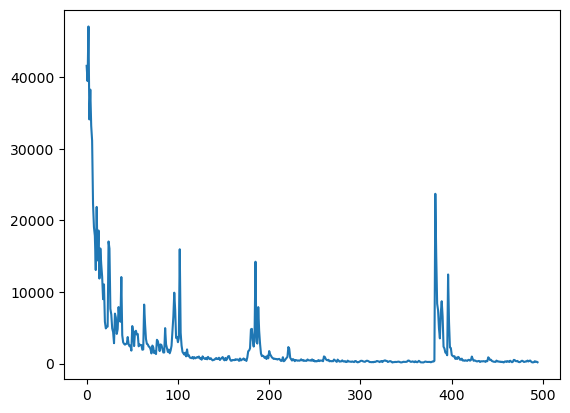

In [48]:
#plt.plot(val_loss, label   ='Validation loss')
plt.plot(train_loss[5:], label='Training loss')

In [49]:
regression_model.eval()
total_test_loss = 0
yhat = []
y = []
with torch.no_grad():
    for images, targets in test_loader:
        #images = c(images)
        images, targets = images.to(device), targets.to(device)
        outputs = regression_model(images)
        yhat.append(outputs.squeeze().cpu().numpy().tolist())
        y.append(targets.cpu().numpy().tolist())
        loss = criterion(outputs.squeeze(), targets.float())  
        total_test_loss += loss.item()

avg_test_loss = np.sqrt(total_test_loss / len(test_loader))
print(f"Test RMSE: {avg_test_loss}")

y = np.array(y, dtype=object)
yhat = np.array(yhat , dtype=object)
y = np.concatenate(y)
#yhat = np.concatenate(yhat)

/home/luizf/miniconda3/envs/neuralforecast/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE: 20.313045840686485


In [50]:
#save model
#torch.save(regression_model.state_dict(), 'model4_20rmse.pth')

In [51]:
df = pd.DataFrame(columns=['yhat', 'y'])
df['yhat'] = yhat
df['y'] = y
df.sort_values(by=['y'], inplace=True)

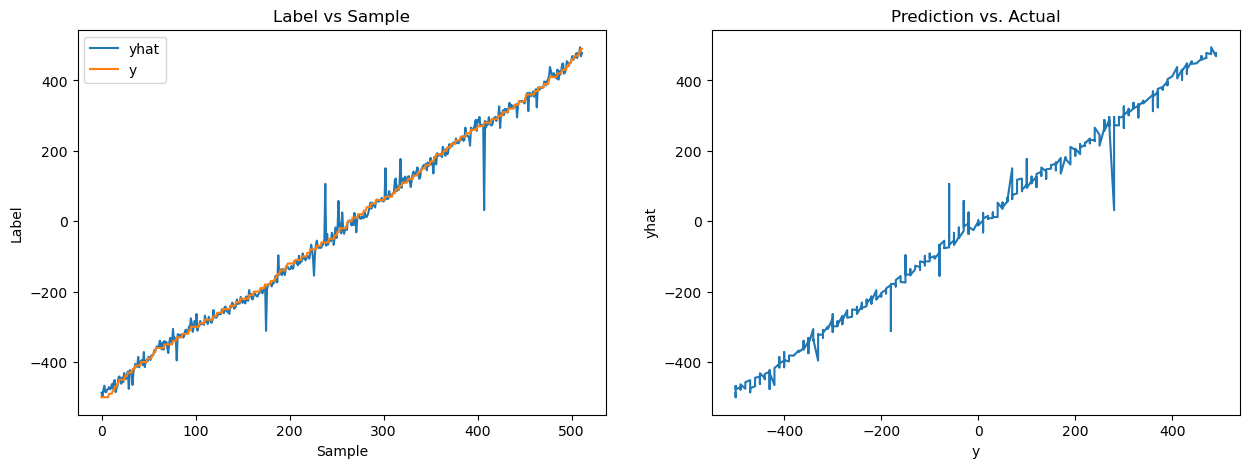

In [52]:
#create suplot with 2 columns and 1 row
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(df['yhat'].values)
ax[0].plot(df['y'].values)
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Label')
ax[0].legend(['yhat', 'y'])
ax[0].set_title('Label vs Sample')

ax[1].plot(df['y'].values, df['yhat'].values)
ax[1].set_xlabel('y')
ax[1].set_ylabel('yhat')
ax[1].set_title('Prediction vs. Actual')

plt.show()

In [20]:
df

yhat      y
351 -489.310608 -500.0
464 -477.428101 -500.0
425 -465.658356 -500.0
24    -477.9328 -500.0
263 -477.887543 -500.0
..          ...    ...
183  485.178192  470.0
456  482.839325  480.0
267  484.970306  480.0
10   483.797089  490.0
367  483.143402  490.0

[512 rows x 2 columns]

# Test with the new video data

In [21]:
del train_loader
del test_loader
torch.cuda.empty_cache()

In [22]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('data2')):
    for filename in tqdm(sorted(filenames, key=lambda x: int(re.sub('\D', '', x)))):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data)/255

100%|██████████| 442/442 [00:00<00:00, 5132.11it/s]


In [23]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
data_t = np.transpose(padded_data, (0, 3, 1, 2))
data_t = torch.from_numpy(data_t).to(device)

In [24]:
dl = DataLoader(data_t, batch_size=40, shuffle=False)

In [25]:
yhats = []
imgs = []
for i in dl:
    yhat = regression_model (i)
    imgs.append(i.detach().cpu().numpy())
    yhats.append(yhat.detach().cpu().numpy())
    del yhat
    torch.cuda.empty_cache()

In [26]:
yhats = np.concatenate(yhats)
imgs = np.concatenate(imgs)

In [27]:
imgs = np.transpose(imgs, (0,2,3,1))

In [28]:
r = np.arange(0, len(yhats)/20, 1/20)

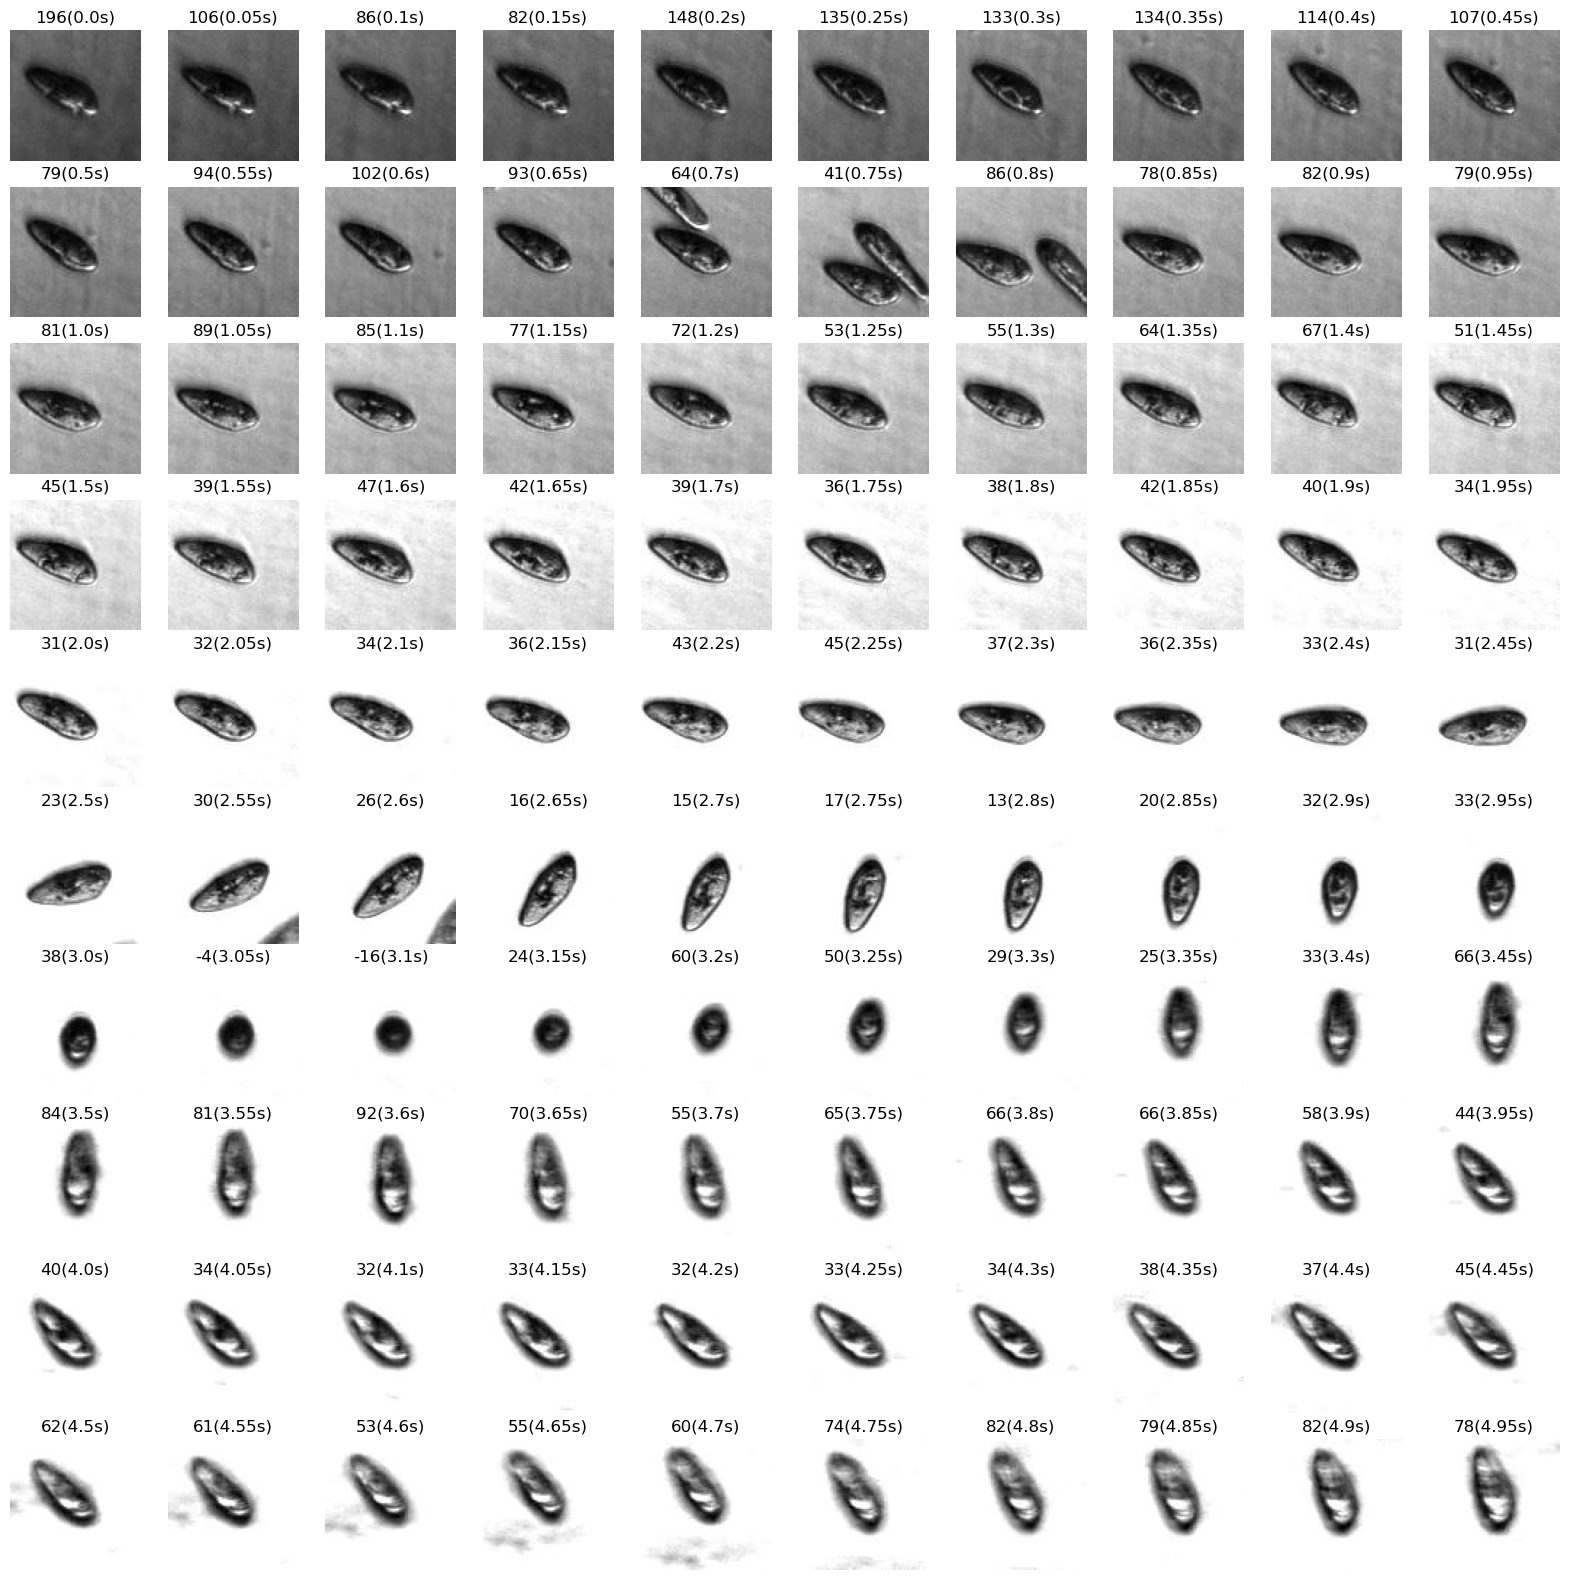

In [29]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax[i//10, i%10].imshow(imgs[i, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(str(int(yhats[i]))+ '(' + str(np.round(r[i],2)) + 's)')
    ax[i//10, i%10].axis('off')

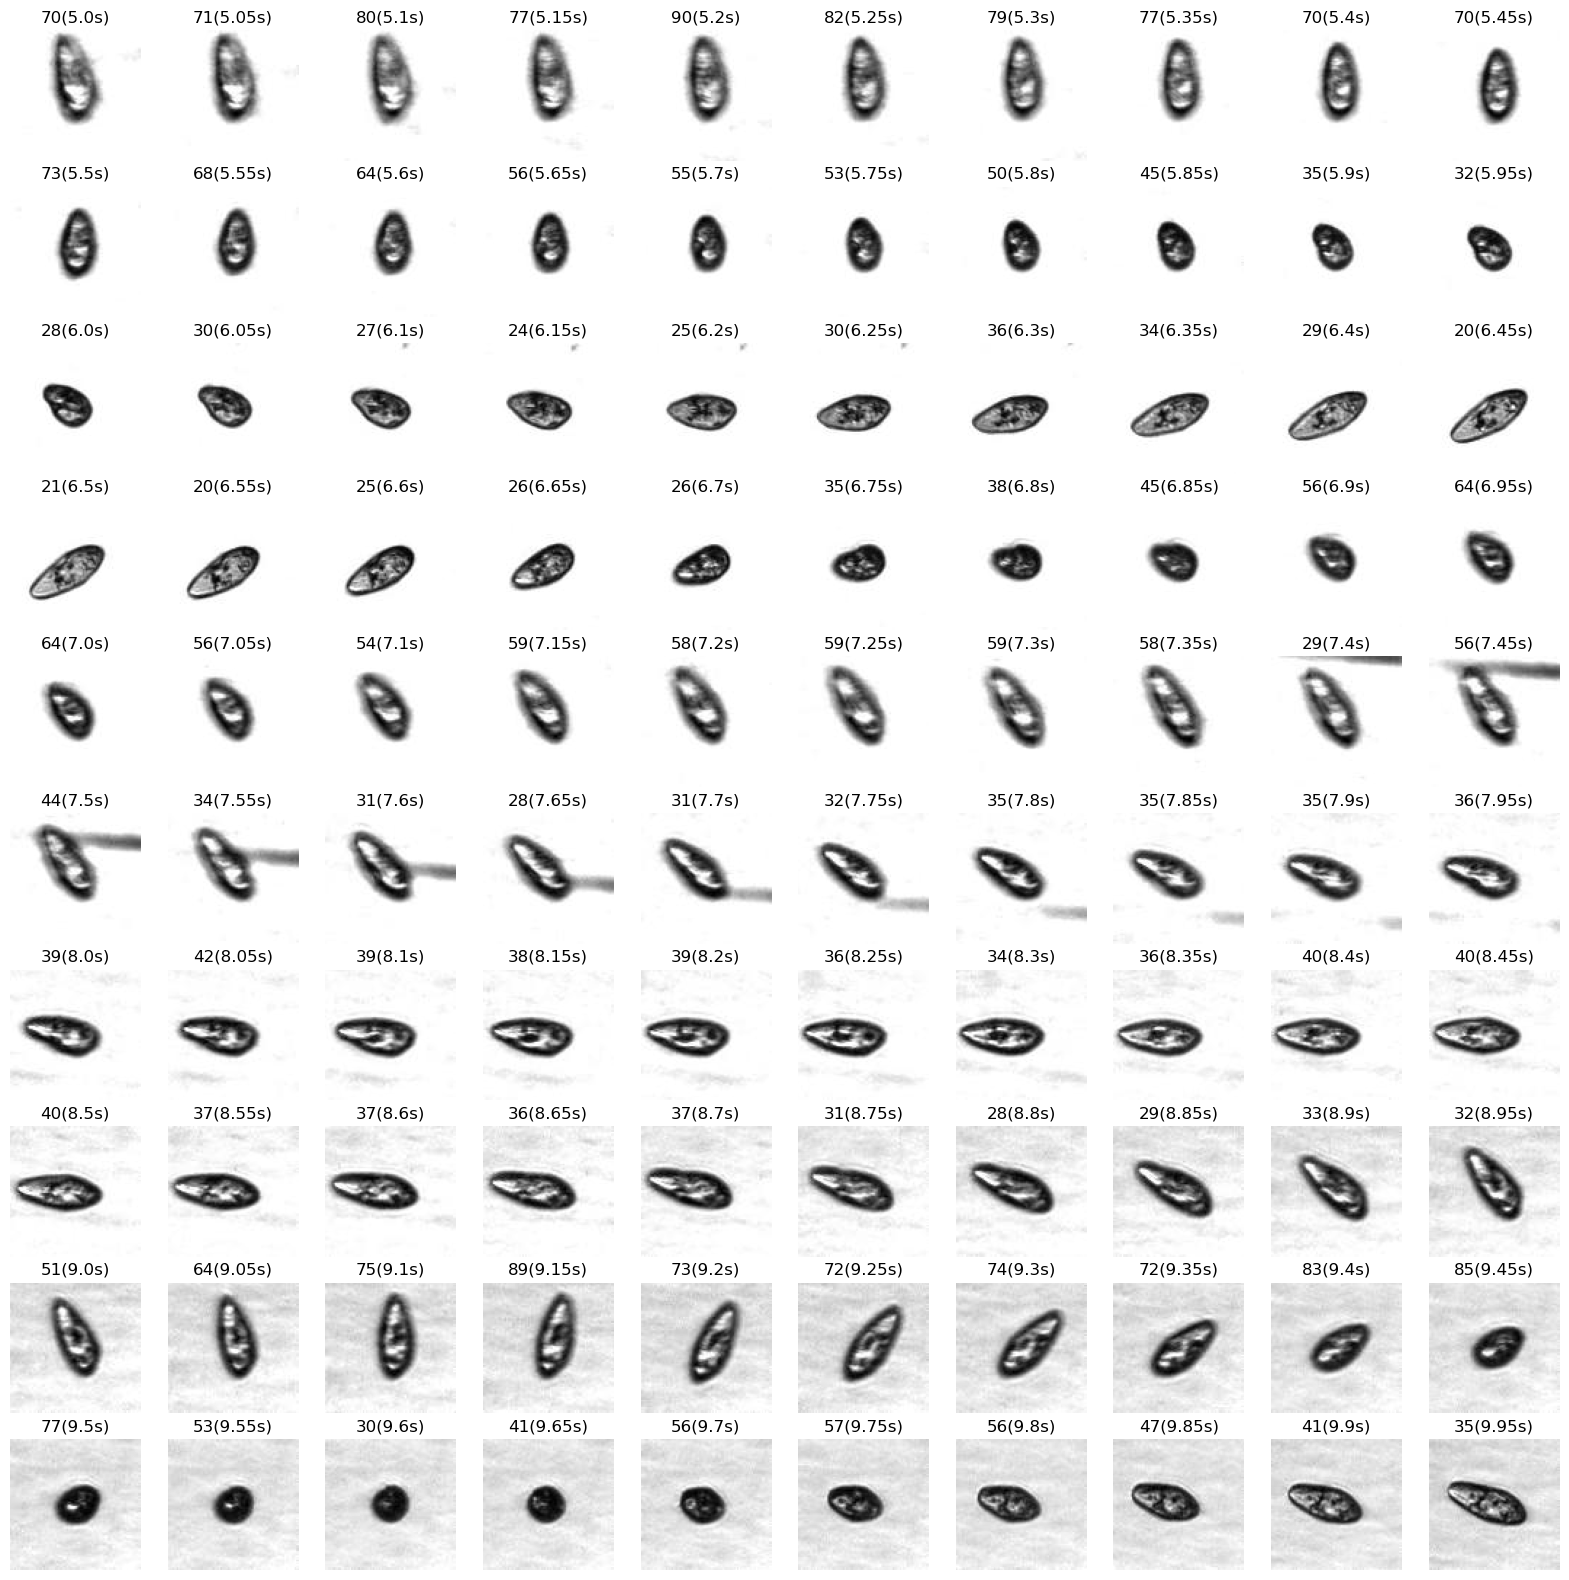

In [30]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(100, 200)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(str(int(yhats[j]))+ '(' + str(np.round(r[j],2)) + 's)')
    ax[i//10, i%10].axis('off')

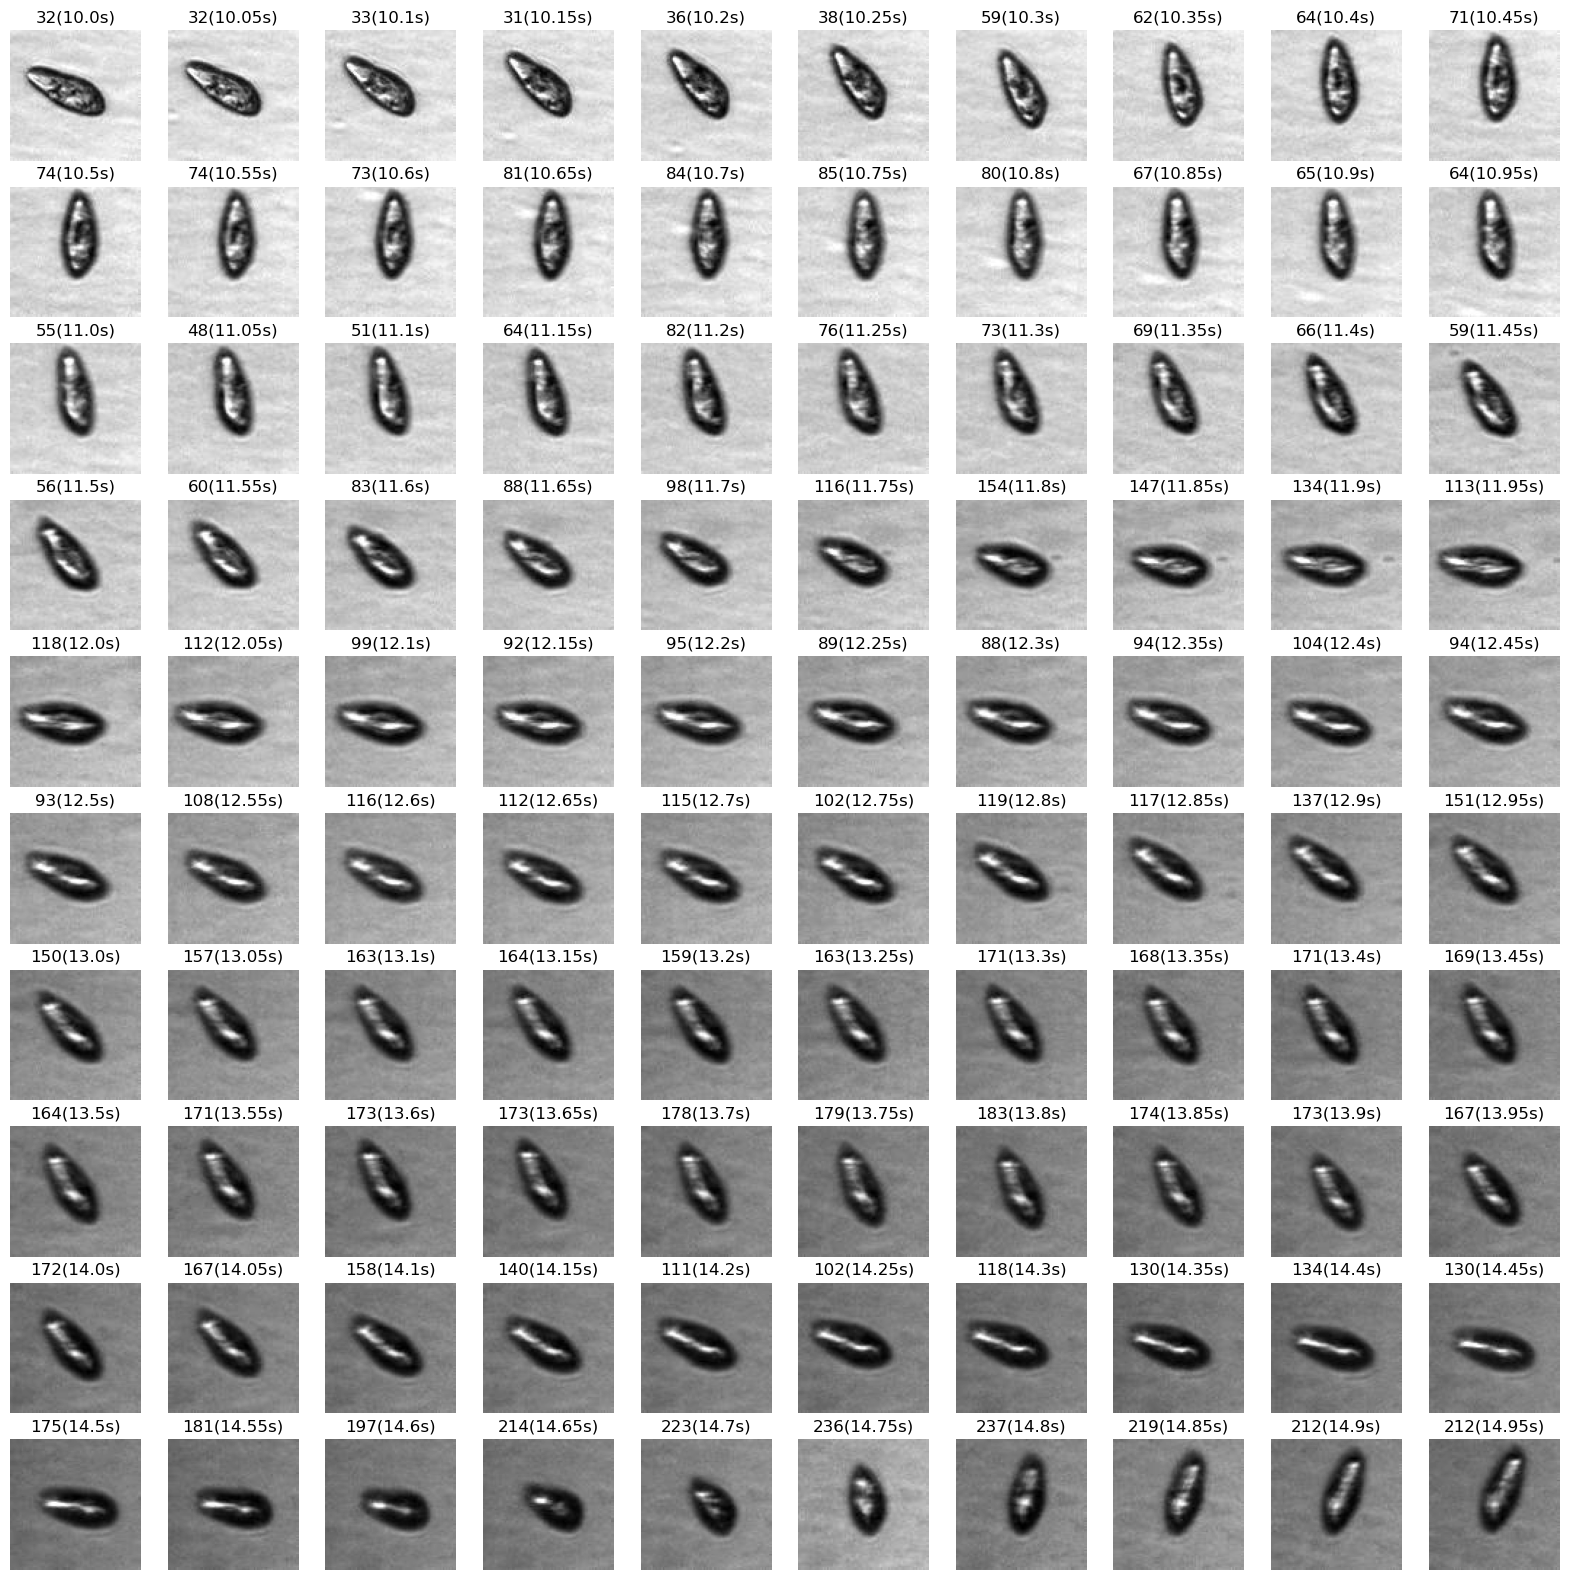

In [31]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(200, 300)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(str(int(yhats[j]))+ '(' + str(np.round(r[j],2)) + 's)')
    ax[i//10, i%10].axis('off')

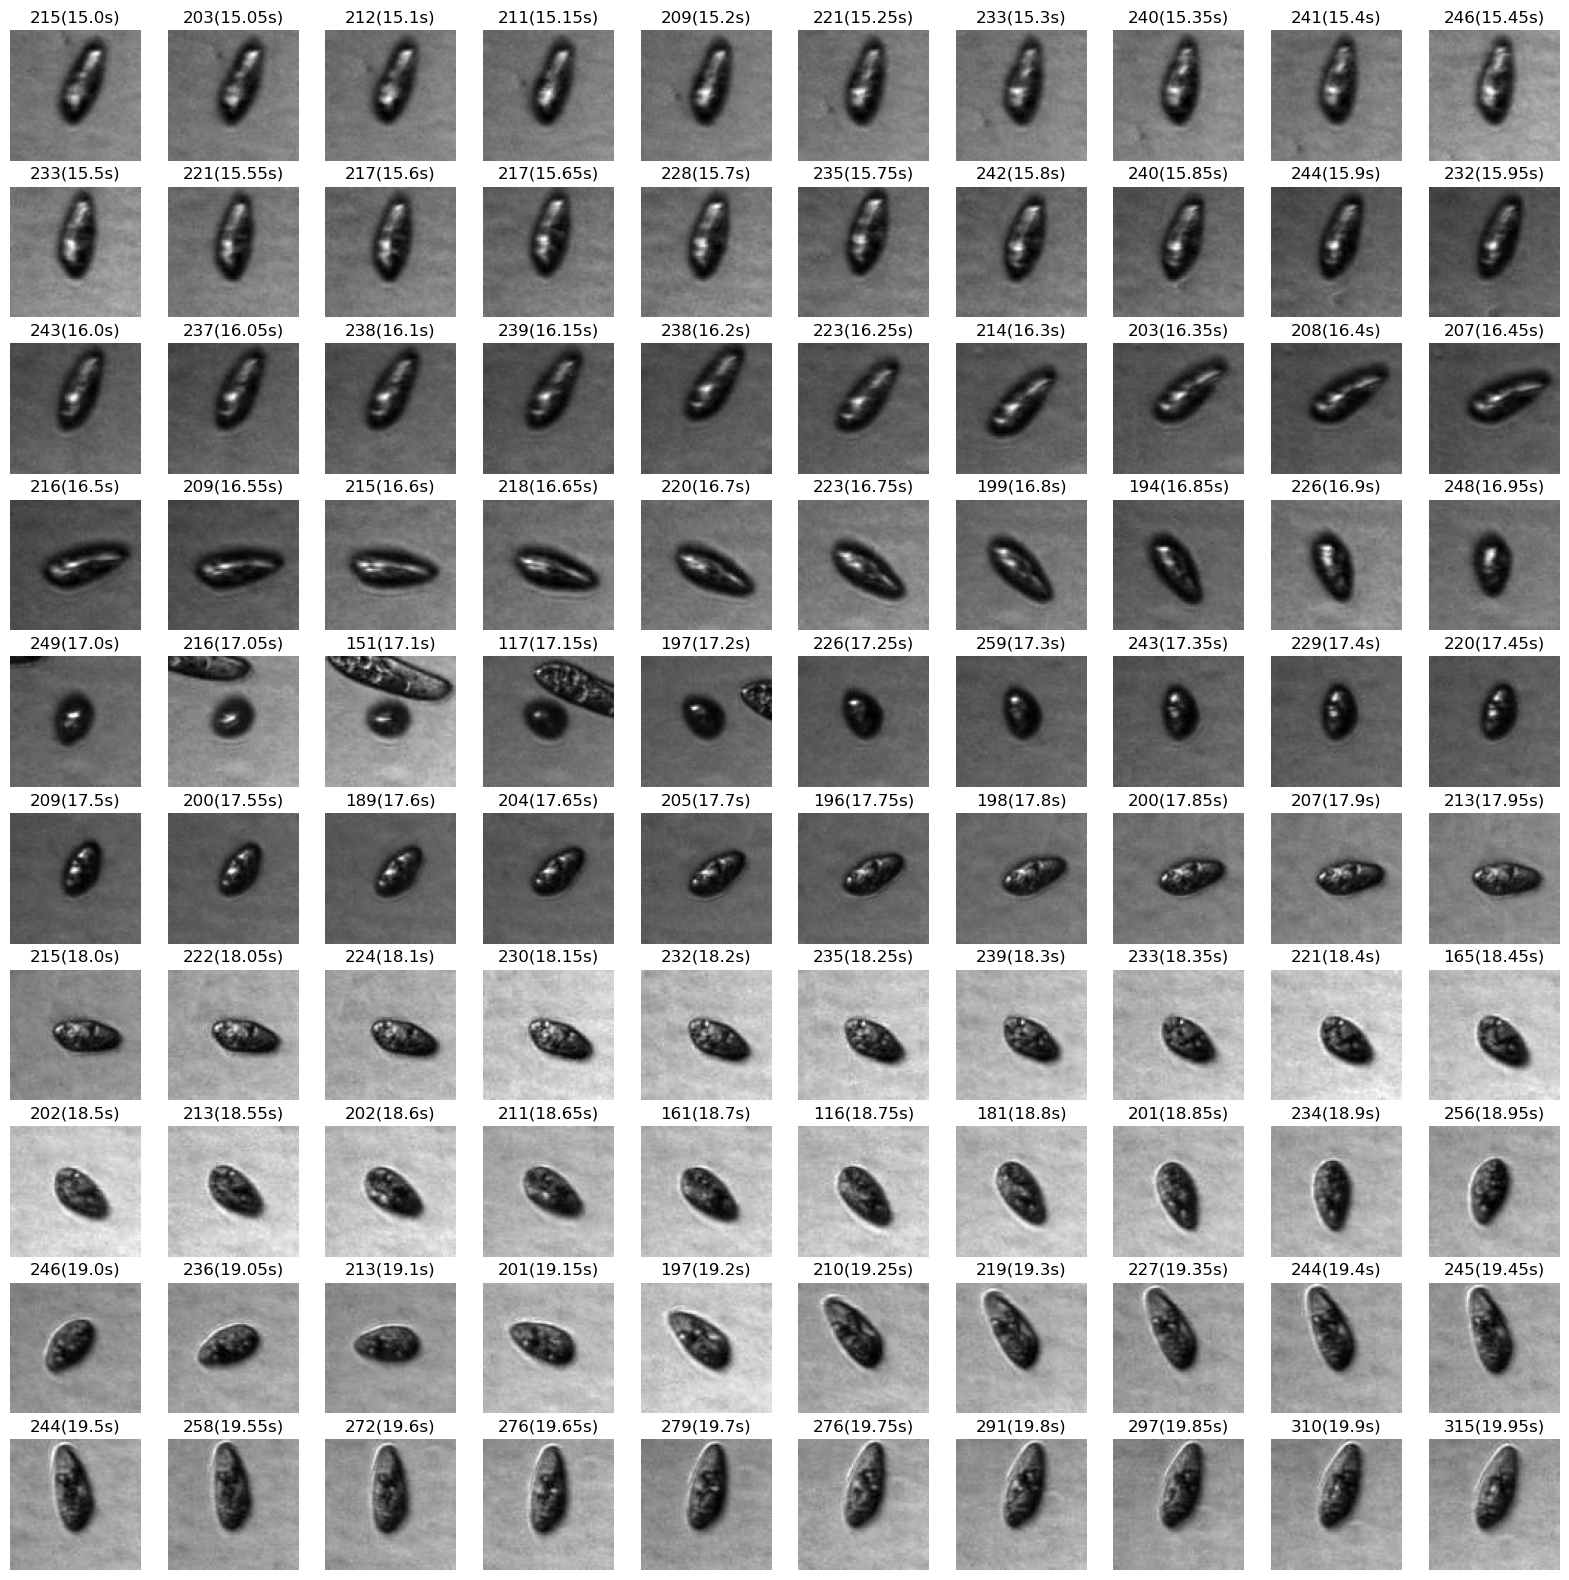

In [32]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(300, 400)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(str(int(yhats[j]))+ '(' + str(np.round(r[j],2)) + 's)')
    ax[i//10, i%10].axis('off')

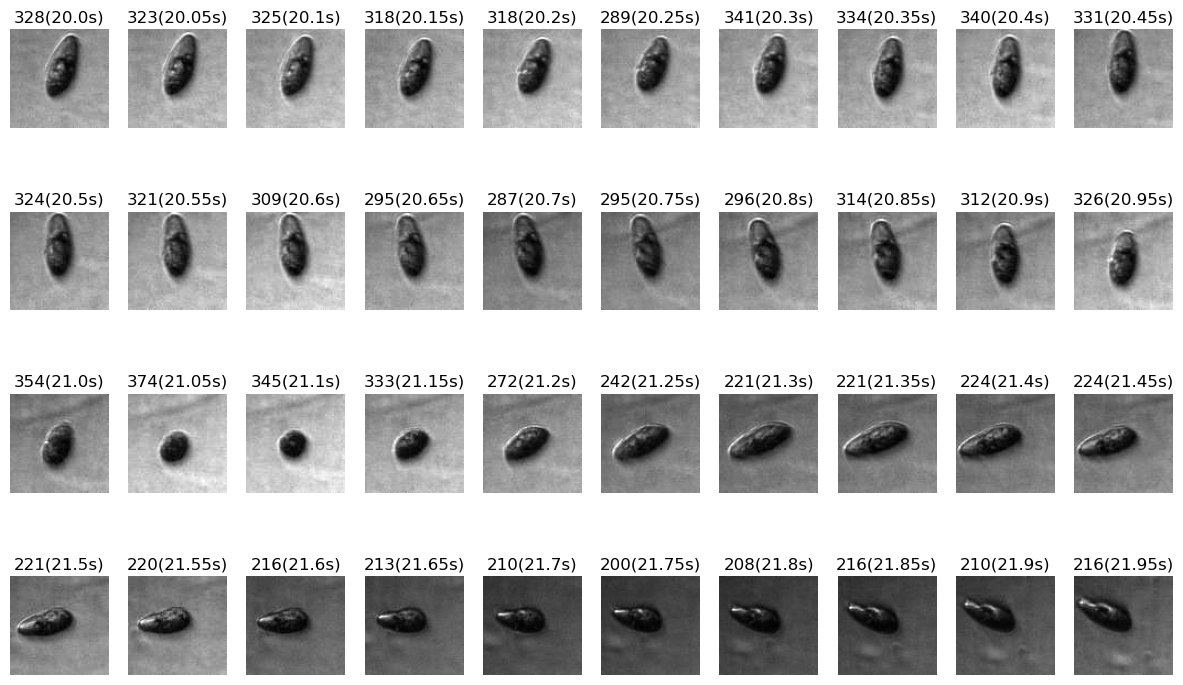

In [33]:

fig, ax = plt.subplots(4, 10, figsize=(15, 15))
for i,j in enumerate(range(400, 440)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(str(int(yhats[j]))+ '(' + str(np.round(r[j],2)) + 's)')
    ax[i//10, i%10].axis('off')



    #decrease distance betweeen subplots
    plt.subplots_adjust( hspace=-0.7)

In [36]:
#Save yhats to txt
np.savetxt("yhat.txt", yhats, fmt="%s")

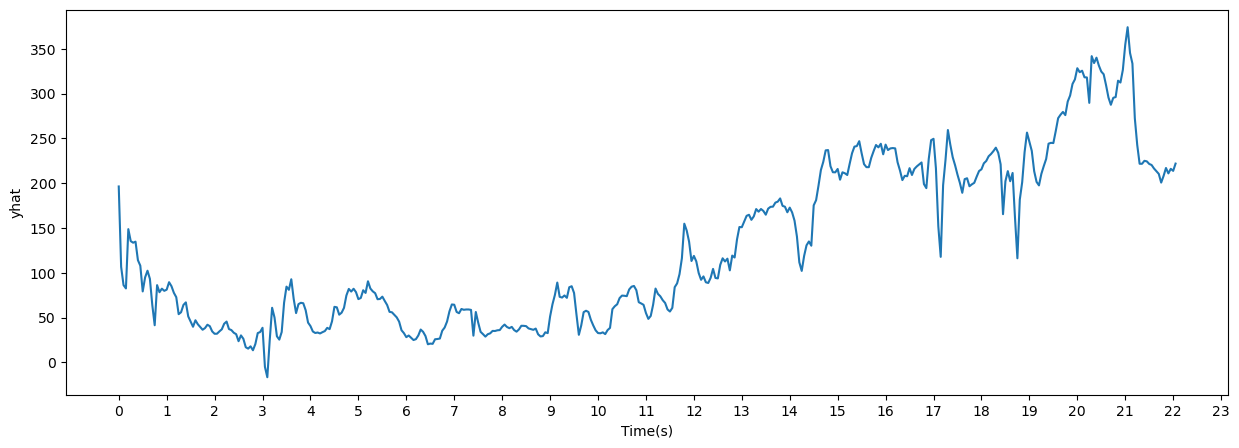

In [34]:
plt.figure(figsize=(15, 5))
plt.plot (r, yhats)
plt.ylabel('yhat')
plt.xlabel('Time(s)')
#make the x scale more precise
plt.xticks(np.arange(min(r), max(r)+1, 1))
plt.show()

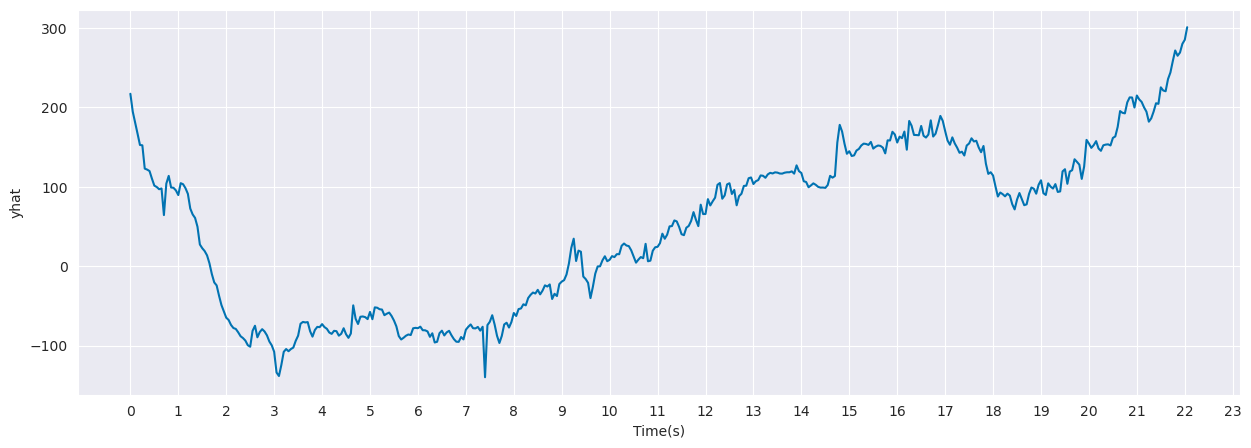

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot (r, yhats)
plt.ylabel('yhat')
plt.xlabel('Time(s)')
#make the x scale more precise
plt.xticks(np.arange(min(r), max(r)+1, 1))
plt.show()